In [2]:
"""
All tastes stacked
Different lambdas for each taste but same tau
ALL NEURONS
"""

'\nAll tastes stacked\nDifferent lambdas for each taste but same tau\nALL NEURONS\n'

In [28]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import theano

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
plt.set_cmap('viridis')
from matplotlib.lines import Line2D
import glob
import json
from scipy.stats import spearmanr
from tqdm import tqdm
from scipy.stats import percentileofscore
import pickle
from sklearn.decomposition import PCA as pca
from scipy.ndimage import gaussian_filter1d
from pingouin import mwu,kruskal, read_dataset
import xarray as xr
import pandas as pd
import seaborn as sns

os.chdir('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

<Figure size 432x288 with 0 Axes>

In [4]:
data_dir = '/media/bigdata/Abuzar_Data/AM12/AM12_4Tastes_191106_085215/'
dat = \
    ephys_data(data_dir)
dat.firing_rate_params = dat.default_firing_params
# dat.firing_rate_params['type'] = 'baks'
# dat.firing_rate_params['baks_resolution'] = 10e-3

dat.get_unit_descriptors()
dat.get_spikes()
dat.get_firing_rates()
dat.get_stft()
print(np.array(dat.spikes).shape)

All tastes have equal dimensions,concatenating and normalizing


/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/tables/leaf.py:410: PerformanceWarning: The Leaf ``/stft/stft_array`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/tables/leaf.py:410: PerformanceWarning: The Leaf ``/stft/amplitude_array`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in

(4, 30, 18, 7000)


(18, 120, 271)


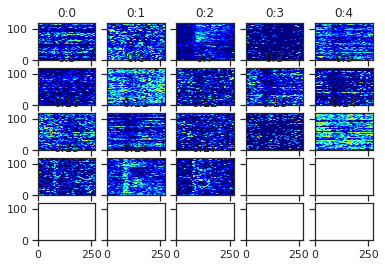

In [5]:
visualize.firing_overview(dat.all_normalized_firing);
print(dat.all_normalized_firing.shape)

In [6]:
print(dat.amplitude_array.shape)
print(dat.time_vec)

(4, 16, 30, 10, 5000)
[0.000e+00 1.000e-03 2.000e-03 ... 4.997e+00 4.998e+00 4.999e+00]


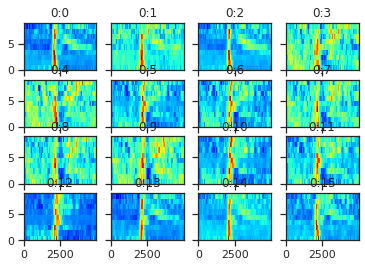

In [7]:
median_amplitude = np.median(dat.amplitude_array,axis=(0,2))
visualize.firing_overview(stats.zscore(median_amplitude,axis=-1));

(16, 10, 5000)
[array([ 0,  1,  2, 13, 14, 15]), array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])]
[ 0  1  2 13 14 15]


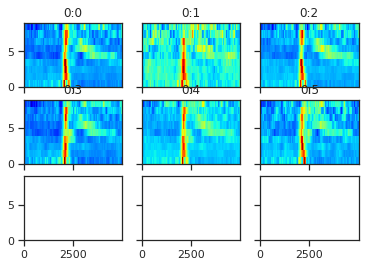

In [8]:
dat.get_lfp_electrodes()
print(median_amplitude.shape)
print(dat.lfp_region_electrodes)
gc_electrodes = dat.lfp_region_electrodes[[num for num,x in enumerate(dat.region_names) if x=='gc'][0]]
print(gc_electrodes)
visualize.firing_overview(stats.zscore(median_amplitude[gc_electrodes],axis=-1));

(4, 30, 10, 2000)
(120, 10, 2000)
(10, 240000)


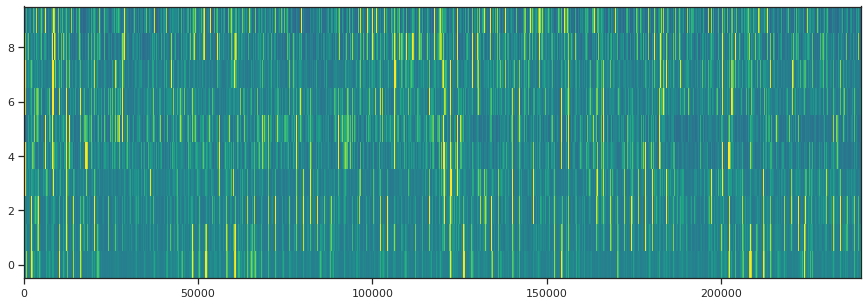

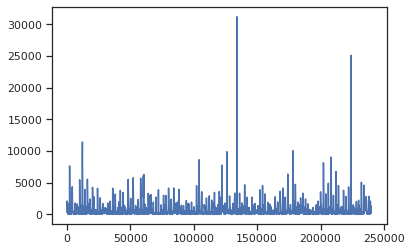

In [11]:
# PCA on single channel
time_lims = [2000,4000]
channel = 0
this_amp_array = dat.amplitude_array[:,gc_electrodes[channel]]
# Cut by time_lims, smaller period means lower chance for artifacts
# This is dangerous in general though since pre and post stim time for stft is not properly accessible
this_amp_array = this_amp_array[...,time_lims[0]:time_lims[1]]
print(this_amp_array.shape)
this_amp_array_long = np.reshape(this_amp_array,(-1,*this_amp_array.shape[2:]))
print(this_amp_array_long.shape)
# Concatenate time trials along time axis for pca
this_amp_array_very_long = np.reshape(np.swapaxes(this_amp_array_long,0,1),(this_amp_array.shape[2],-1))
print(this_amp_array_very_long.shape)
plt.figure(figsize=(15,5))
thresh = 3
plt.imshow(stats.zscore(this_amp_array_very_long,axis=-1),aspect='auto',vmin = -thresh, vmax = thresh, origin='lower', cmap='viridis');
plt.figure()
plt.plot(this_amp_array_very_long[1])

In [12]:
# Find median absolute deivation for each frequency
# And remove trials with power higher than those
freq_med = np.median(this_amp_array_very_long,axis=-1)
MAD = np.median(np.abs((this_amp_array_very_long - freq_med[:,np.newaxis])),axis=-1)
print(MAD.shape)
print(freq_med)
print(MAD)

(10,)
[111.30520934 333.57699577 336.55950556 237.5281561  251.1533548
 155.21330131  71.21833494  55.24242152  53.61153425  51.91369224]
[104.12207882 255.01759649 259.41650197 179.37919492 172.05877719
 108.41110468  50.89310932  39.71127887  37.59133657  37.370481  ]


[ -5094.7987316  -12417.30282861 -12634.26559282  -8731.43158982
  -8351.78550468  -5265.34193244  -2473.43713101  -1930.32152219
  -1825.95529405  -1816.61035771]
18


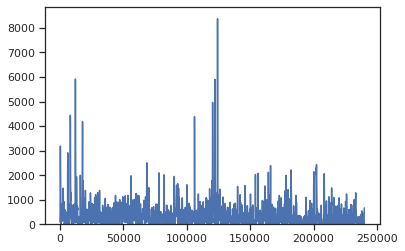

In [13]:
# Iterate through trials and remove ones outside thresholds
threshold = 50 # MADs from the median
lower_lim = freq_med - (threshold * MAD)
upper_lim = freq_med + (threshold * MAD)
freq = 4
plt.plot(this_amp_array_very_long[freq])
plt.ylim((0,upper_lim[freq]))

print(lower_lim)
outlier_trial_set = set()
for num, this_freq in enumerate(this_amp_array_long.swapaxes(0,1)):
#     num = 4
    this_freq = this_amp_array_long[:,num]
#     print(this_freq.shape)
    this_ll,this_ul = lower_lim[num],upper_lim[num]
#     print(this_ll,this_ul)
    outlier_inds = np.where(this_freq > this_ul)
    outlier_trial_set = outlier_trial_set.union(set(outlier_inds[0]))
#     print(len(outlier_inds[0]))
#     print(np.sort(np.unique(outlier_inds[0])))
print(len(outlier_trial_set))

(102, 10, 2000)
(10, 204000)


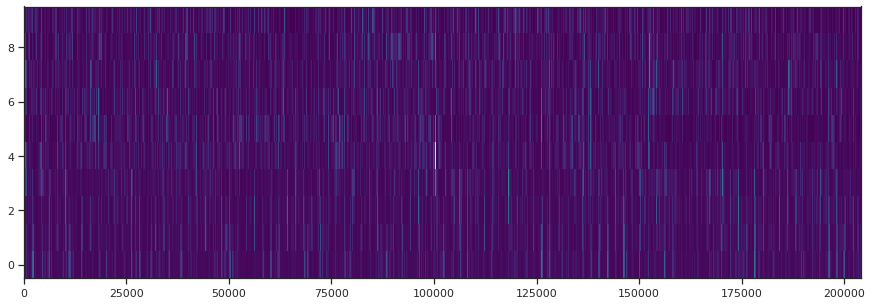

In [16]:
clean_trial_inds = [x for x in np.arange(this_amp_array_long.shape[0]) if x not in outlier_trial_set]
clean_this_amp_long = this_amp_array_long[np.array(clean_trial_inds)]
print(clean_this_amp_long.shape)
clean_amp_very_long = np.reshape(clean_this_amp_long.swapaxes(0,1),(len(dat.freq_vec),-1))
print(clean_amp_very_long.shape)
plt.figure(figsize=(15,5))
# thresh = 5
plt.imshow(stats.zscore(clean_amp_very_long,axis=-1),aspect='auto',origin='lower',cmap='viridis');

(102, 5, 2000)


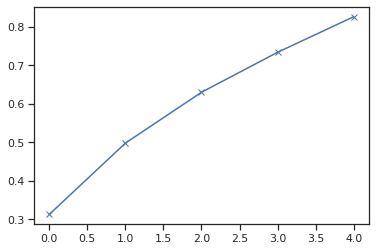

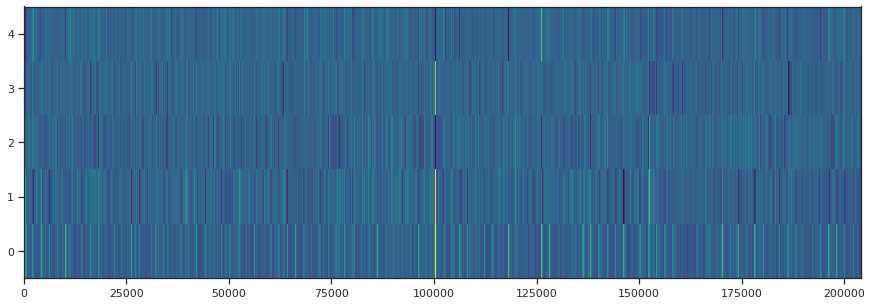

In [18]:
# Find PC's for clean data
n_components = 5
# zscore_smooth_amp_v_long = gaussian_filter1d(stats.zscore(clean_amp_very_long,axis=-1),sigma = 50)
zscpre_amp_v_long = stats.zscore(clean_amp_very_long,axis=-1)
pca_obj = pca(n_components= n_components).fit(zscpre_amp_v_long.T)
reduced_stft_long = np.array([pca_obj.transform(x.T) for x in clean_this_amp_long]).swapaxes(-2,-1)
print(reduced_stft_long.shape)

plt.plot(np.cumsum(pca_obj.explained_variance_ratio_),'x-')

reduced_stft_long_long = pca_obj.transform(zscpre_amp_v_long.T).T
plt.figure(figsize=(15,5))
plt.imshow(reduced_stft_long_long,aspect='auto',origin='lower',cmap='viridis');

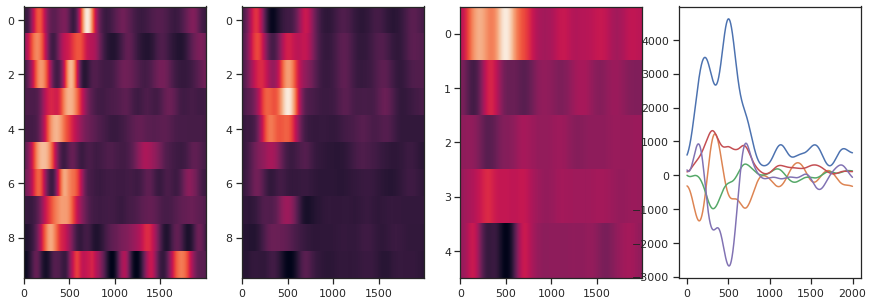

In [19]:
trial = 0
fig,ax = plt.subplots(1,4,figsize = (15,5))
ax[0].imshow(stats.zscore(clean_this_amp_long[trial],axis=-1),aspect='auto')
ax[1].imshow(pca_obj.components_.T.dot(reduced_stft_long[trial]),aspect='auto')
ax[2].imshow(reduced_stft_long[trial],aspect='auto')
ax[3].plot(reduced_stft_long[trial].T);

[ 0  1  2  3 15 16 17]
(4, 30, 7, 7000)
7


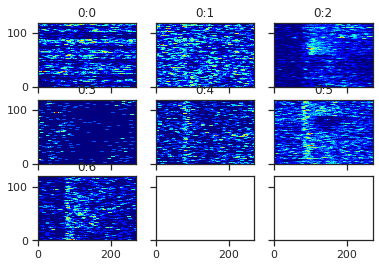

In [20]:
dat.get_region_units()
# print(dat.region_names)
# print(dat.region_units)
# Extract GC units
gc_units = dat.region_units[[num for num,x in enumerate(dat.region_names) if x=='gc'][0]]
print(gc_units)
fin_spikes = np.array(dat.spikes)[:,:,gc_units]
print(fin_spikes.shape)
visualize.firing_overview(dat.all_normalized_firing[gc_units]);
print(len(gc_units))

In [21]:
# nrn = np.arange(np.array(dat.spikes).shape[2])
nrn = np.arange(np.array(fin_spikes).shape[2])
taste_dat = np.array(fin_spikes)[:,:,nrn]
#taste_dat = np.array(dat.spikes)[:,:,nrn]
print(taste_dat.shape)

(4, 30, 7, 7000)


In [22]:
# Convert spikes to counts by binning
bin_width = 25
t_vec = np.arange(taste_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
whole_dat_binned = np.sum(taste_dat.reshape(*taste_dat.shape[:-1],-1,bin_width),axis=-1)
this_dat_binned = np.sum(taste_dat[...,time_lims[0]:time_lims[1]].reshape(*taste_dat.shape[:-1],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)

print(this_dat_binned.shape)
print(whole_dat_binned.shape)
# print(binned_t_vec)

(4, 30, 7, 80)
(4, 30, 7, 280)


(4, 7, 80)


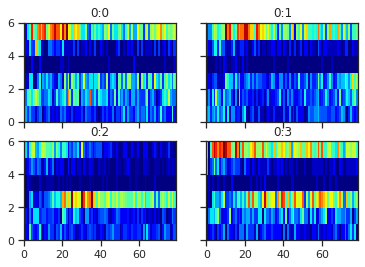

In [23]:
mean_this_dat = np.mean(this_dat_binned,axis=1)
print(mean_this_dat.shape)
visualize.firing_overview(mean_this_dat);

(120, 7, 80)
(120, 7, 280)


<Figure size 432x288 with 0 Axes>

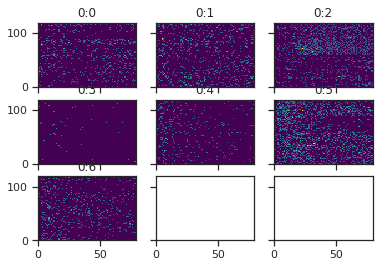

In [24]:
# Pick single trial
trial = np.arange(taste_dat.shape[1])
taste = np.arange(taste_dat.shape[0])

dat_binned_long = np.reshape(this_dat_binned,(-1,*this_dat_binned.shape[-2:]))
whole_dat_binned_long = np.reshape(whole_dat_binned,(-1,*whole_dat_binned.shape[-2:]))
print(dat_binned_long.shape)
plt.figure();
visualize.firing_overview(dat_binned_long.swapaxes(0,1),cmap='viridis');
print(whole_dat_binned_long.shape)
#dat_binned_long[dat_binned_long>1] = 1
# plt.figure();
# visualize.firing_overview(dat_binned_long.swapaxes(0,1),cmap='viridis');

In [25]:
clean_dat_binned_long = dat_binned_long[clean_trial_inds]
print(clean_dat_binned_long.shape)
zscore_amp_long = stats.zscore(clean_this_amp_long,axis=-1)

(102, 7, 80)


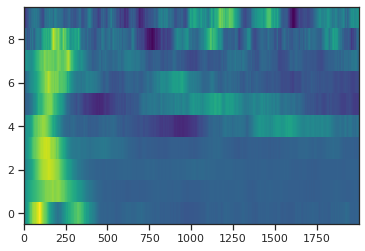

In [26]:
visualize.imshow(stats.zscore(np.median(clean_this_amp_long,axis=0),axis=-1))

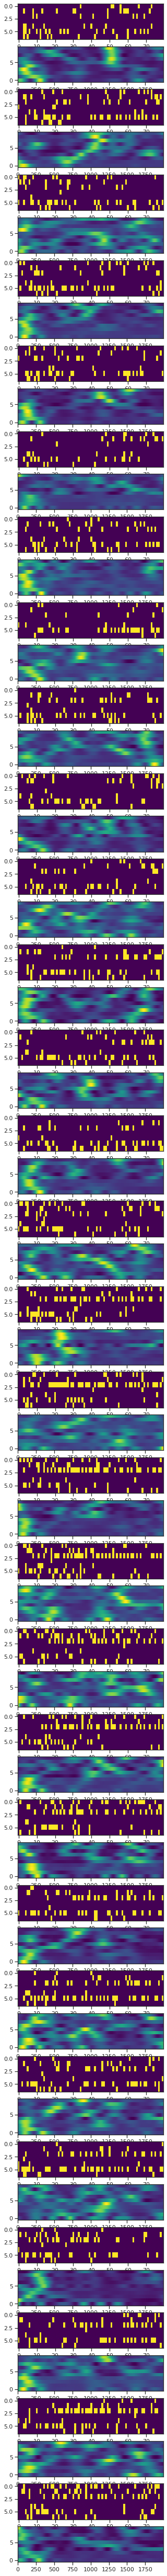

In [29]:
# Overlay raster with CDF of switchpoints
trial_count = 30
trial_inds = np.sort(np.random.choice(np.arange(clean_dat_binned_long.shape[0]),trial_count, replace = False))

fig, ax = plt.subplots(trial_count*2, figsize = (5,3*trial_count))
for num,trial in enumerate(trial_inds):
    ax[num*2].imshow(clean_dat_binned_long[trial]>0,aspect = 'auto')
    ax[num*2+1].imshow(zscore_amp_long[trial],interpolation='nearest',aspect='auto',origin='lower')
#     ax[num,2].imshow(reduced_stft_long[trial],interpolation='nearest',aspect='auto',origin='lower')

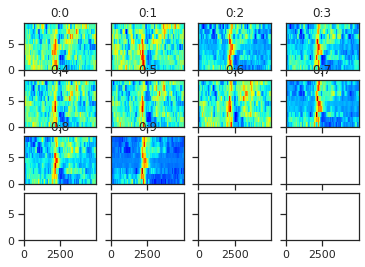

In [30]:
# If BLA present, plot BLA and GC spectra side-by-side
if 'bla' in dat.region_names:
    bla_electrodes = dat.lfp_region_electrodes[[num for num,x in enumerate(dat.region_names) if x=='bla'][0]]
    visualize.firing_overview(stats.zscore(median_amplitude[bla_electrodes],axis=-1));

In [31]:
this_bla_amp_array = dat.amplitude_array[:,bla_electrodes[channel]]
this_bla_amp_array = this_bla_amp_array[...,time_lims[0]:time_lims[1]]
print(this_bla_amp_array.shape)
bla_amp_long = np.reshape(this_bla_amp_array,(-1,*this_bla_amp_array.shape[2:]))
print(bla_amp_long.shape)
bla_amp_clean = bla_amp_long[clean_trial_inds]
print(bla_amp_clean.shape)
bla_zscore_amp_long = stats.zscore(bla_amp_clean,axis=-1)

(4, 30, 10, 2000)
(120, 10, 2000)
(102, 10, 2000)


In [32]:
dat.freq_vec

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.])

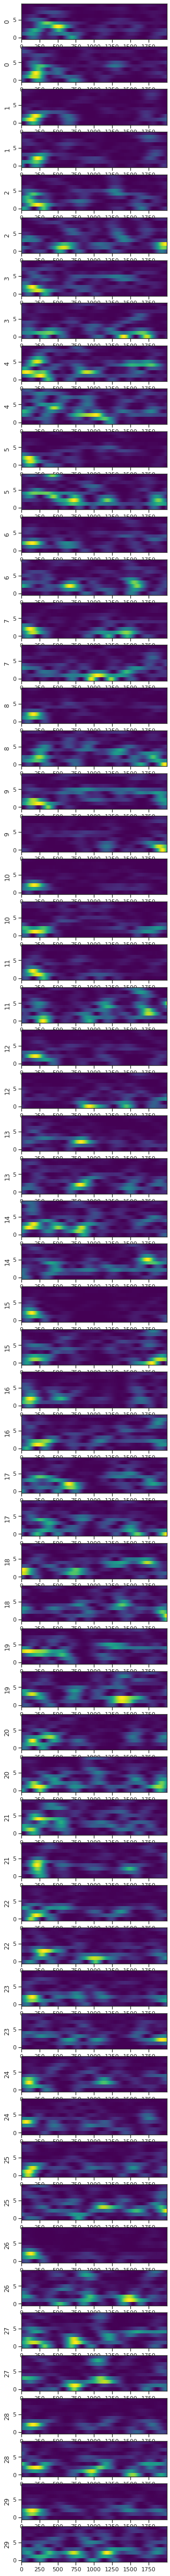

In [33]:
# Overlay raster with CDF of switchpoints
trial_count = 30
trial_inds = np.sort(np.random.choice(np.arange(clean_dat_binned_long.shape[0]),trial_count, replace = False))

fig, ax = plt.subplots(trial_count*2, figsize = (5,3*trial_count))
for num,trial in enumerate(trial_inds):
#     ax[num*2].imshow(zscore_amp_long[trial],interpolation='nearest',aspect='auto',origin='lower')
#     ax[num*2+1].imshow(bla_zscore_amp_long[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num*2].imshow(clean_this_amp_long[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num*2+1].imshow(bla_amp_clean[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num*2].set_ylabel(num)
    ax[num*2+1].set_ylabel(num)
# ax[0,0].set_title('GC')
# ax[0,1].set_title('BLA')

Text(0.5, 1.0, 'BLA')

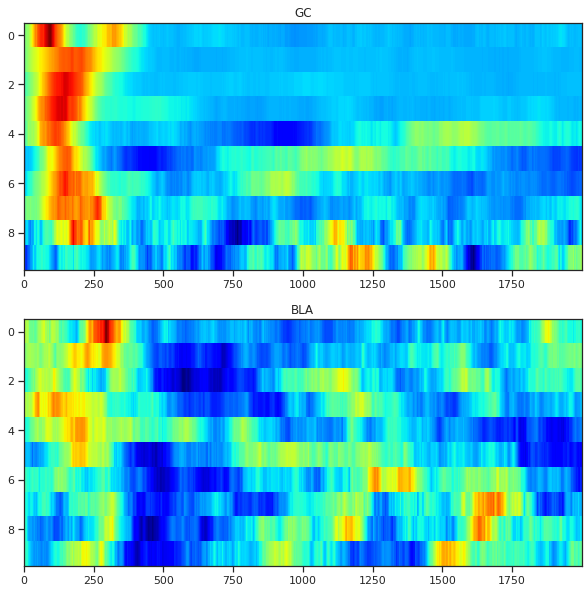

In [34]:
fig,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].imshow(stats.zscore(np.median(clean_this_amp_long,axis=0),axis=-1),aspect='auto',cmap='jet')
ax[1].imshow(stats.zscore(np.median(bla_amp_clean,axis=0),axis=-1),aspect='auto',cmap='jet')
ax[0].set_title('GC')
ax[1].set_title('BLA')

[1.         1.         1.         0.05904321 1.         1.
 1.         1.         1.        ]
[-1. -1. -1. -1. -1. -1. -1. -1. -1.]
[0.03005402 0.20835769 0.07023179 0.02744048 0.07253123 0.00606548
 0.04485018 0.02164737 0.01412874]
[1.         1.         1.         0.05904321 1.         1.
 1.         1.         1.        ]


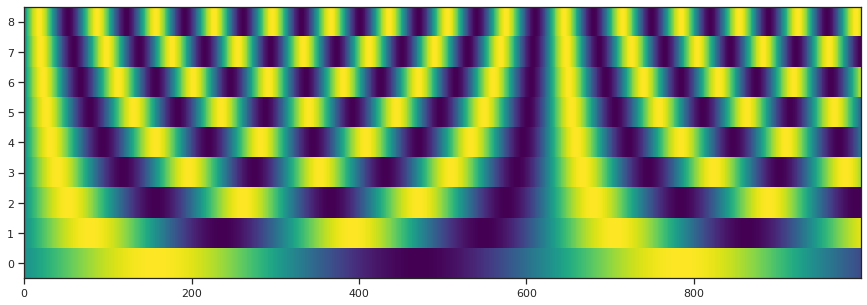

In [35]:
# Perform zero-lag cross-correlation on single trials and shuffled trials
# Use normalized cross-correlation to remove amplitude effects

def norm_zero_lag_xcorr(vec1, vec2):
    """
    Calculates normalized zero-lag cross correlation
    Returns a single number
    """
    auto_v1 = np.sum(vec1**2,axis=-1)
    auto_v2 = np.sum(vec2**2,axis=-1)
    xcorr = np.sum(vec1 * vec2,axis=-1)
    denom = np.sqrt(np.multiply(auto_v1,auto_v2))
    return np.divide(xcorr, denom)

# Testing function
x = np.linspace(0,10,1000)
y1 = np.array([np.sin(x*a) for a in range(1,10)])
y2 = y1/2
y3 = -y1
y4 = np.cos(x)
y5 = y2
y5[3] = np.ones(y5[3].shape)

plt.figure(figsize(15,5))
visualize.imshow(y1)

print(norm_zero_lag_xcorr(y1,y2))
print(norm_zero_lag_xcorr(y1,y3))
print(norm_zero_lag_xcorr(y1,y4))
print(norm_zero_lag_xcorr(y1,y5))

102
[89 27 35 39 16 80 37  5 80 84]
[87 95  7 55 60 80 19  3 83 38]
(102, 10)
(102, 10)


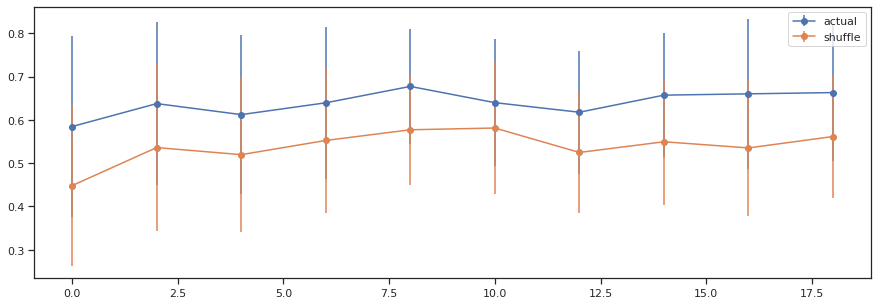

In [36]:
xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(clean_this_amp_long,bla_amp_clean)])
resamples = clean_this_amp_long.shape[0]
print(resamples)
inds1 = np.random.choice(np.arange(clean_this_amp_long.shape[0]),size=resamples)
inds2 = np.random.choice(np.arange(clean_this_amp_long.shape[0]),size=resamples)
print(inds1[:10])
print(inds2[:10])
shuffled_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) \
                            for v1,v2 in zip(clean_this_amp_long[inds1],bla_amp_clean[inds2])])
mean_xcorrs = np.mean(xcorrs,axis=0)
std_xcorrs = np.std(xcorrs,axis=0)
mean_shuffle_xcorrs = np.mean(shuffled_xcorrs,axis=0)
std_shuffle_xcorrs = np.std(shuffled_xcorrs,axis=0)
plt.errorbar(dat.freq_vec,mean_xcorrs,std_xcorrs, label = 'actual',marker = 'o')
plt.errorbar(dat.freq_vec,mean_shuffle_xcorrs,std_shuffle_xcorrs, label = 'shuffle',marker = 'o')
plt.legend();

print(xcorrs.shape)
print(shuffled_xcorrs.shape)


In [37]:
bla_amp_clean.shape

(102, 10, 2000)

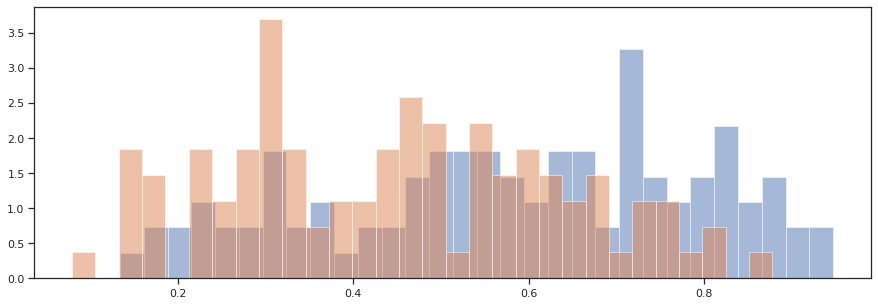

In [38]:
freq = 0
plt.hist(xcorrs[:,freq],30,alpha=0.5,density=True);
plt.hist(shuffled_xcorrs[:,freq],30,alpha=0.5,density=True);

In [39]:
# Perform xcorr between pairs of channels within BLA and GC for reference
channel2 = channel+1

this_gc_amp_array2 = dat.amplitude_array[:,gc_electrodes[channel2]]
this_gc_amp_array2 = this_gc_amp_array2[...,time_lims[0]:time_lims[1]]
print(this_gc_amp_array2.shape)
gc_amp_long2 = np.reshape(this_gc_amp_array2,(-1,*this_gc_amp_array2.shape[2:]))
print(gc_amp_long2.shape)
gc_amp_clean2 = gc_amp_long2[clean_trial_inds]
print(gc_amp_clean2.shape)

this_bla_amp_array2 = dat.amplitude_array[:,bla_electrodes[channel2]]
this_bla_amp_array2 = this_bla_amp_array2[...,time_lims[0]:time_lims[1]]
print(this_bla_amp_array2.shape)
bla_amp_long2 = np.reshape(this_bla_amp_array2,(-1,*this_bla_amp_array2.shape[2:]))
print(bla_amp_long2.shape)
bla_amp_clean2 = bla_amp_long2[clean_trial_inds]
print(bla_amp_clean2.shape)

(4, 30, 10, 2000)
(120, 10, 2000)
(102, 10, 2000)
(4, 30, 10, 2000)
(120, 10, 2000)
(102, 10, 2000)


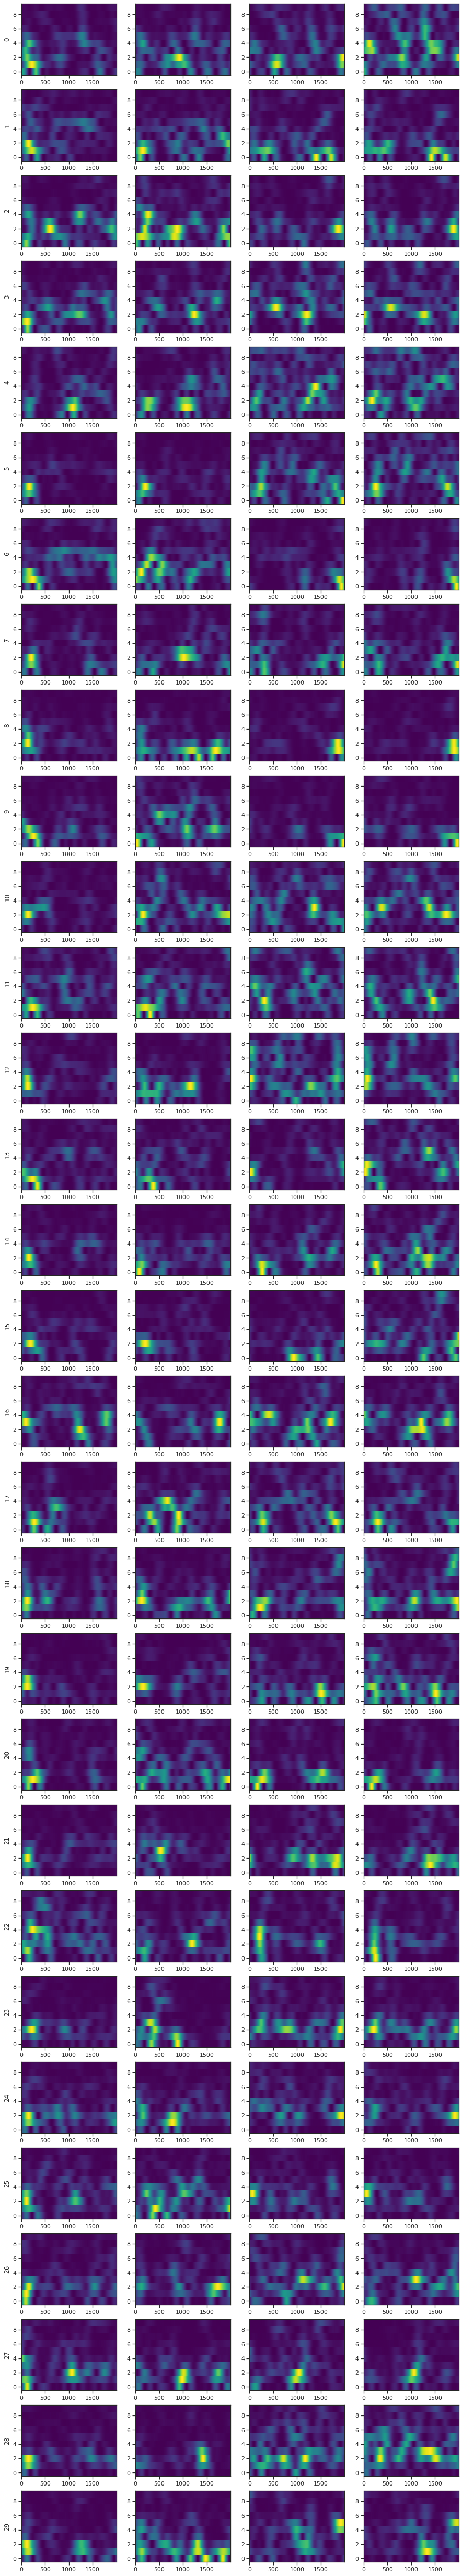

In [40]:
# Plot pairs of electrodes side by side to VISUALIZE similarity
# Overlay raster with CDF of switchpoints
trial_count = 30
trial_inds = np.sort(np.random.choice(np.arange(clean_dat_binned_long.shape[0]),trial_count, replace = False))

fig, ax = plt.subplots(trial_count, 4, figsize = (15,3*trial_count))
for num,trial in enumerate(trial_inds):
    ax[num,0].imshow(clean_this_amp_long[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,1].imshow(gc_amp_clean2[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,2].imshow(bla_amp_clean[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,3].imshow(bla_amp_clean2[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,0].set_ylabel(num)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


102
[90  8  3 86 99 95 82 17 34 86]
[65 97 39 37 53 60 50 89 66 29]
102
[86 57 72 46 92 96 63 97 77 36]
[84 35 17  7 62 13 14  2 51 40]
(10,)
(102, 10)
(102, 10)


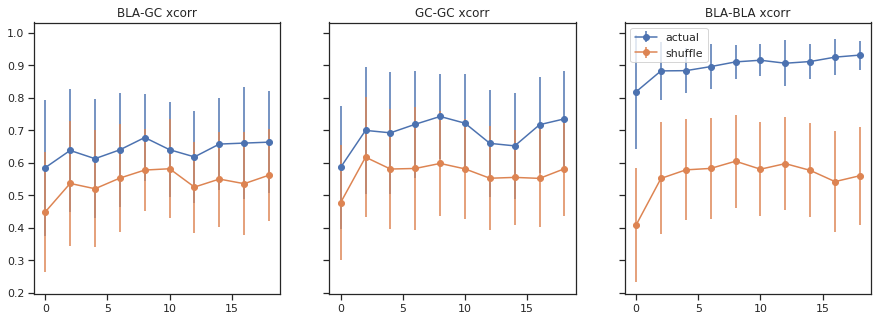

In [41]:
# Intra-GC xcorrs
gc_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(clean_this_amp_long,gc_amp_clean2)])
resamples = clean_this_amp_long.shape[0]
print(resamples)
inds1 = np.random.choice(np.arange(clean_this_amp_long.shape[0]),size=resamples)
inds2 = np.random.choice(np.arange(clean_this_amp_long.shape[0]),size=resamples)
print(inds1[:10])
print(inds2[:10])
gc_shuffled_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) \
                            for v1,v2 in zip(clean_this_amp_long[inds1],gc_amp_clean2[inds2])])
gc_mean_xcorrs = np.mean(gc_xcorrs,axis=0)
gc_std_xcorrs = np.std(gc_xcorrs,axis=0)
gc_mean_shuffle_xcorrs = np.mean(gc_shuffled_xcorrs,axis=0)
gc_std_shuffle_xcorrs = np.std(gc_shuffled_xcorrs,axis=0)

# Intra BLA xcorrs
bla_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(bla_amp_clean,bla_amp_clean2)])
resamples = bla_amp_clean.shape[0]
print(resamples)
inds1 = np.random.choice(np.arange(bla_amp_clean.shape[0]),size=resamples)
inds2 = np.random.choice(np.arange(bla_amp_clean.shape[0]),size=resamples)
print(inds1[:10])
print(inds2[:10])
bla_shuffled_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) \
                            for v1,v2 in zip(bla_amp_clean[inds1],bla_amp_clean2[inds2])])
bla_mean_xcorrs = np.mean(bla_xcorrs,axis=0)
bla_std_xcorrs = np.std(bla_xcorrs,axis=0)
bla_mean_shuffle_xcorrs = np.mean(bla_shuffled_xcorrs,axis=0)
bla_std_shuffle_xcorrs = np.std(bla_shuffled_xcorrs,axis=0)

# Plot cross-region with w/i region
fig,ax = plt.subplots(1,3,sharey=True, figsize = (15,5))
print(mean_xcorrs.shape)
ax[0].errorbar(dat.freq_vec,mean_xcorrs,std_xcorrs, label = 'actual',marker = 'o')
ax[0].errorbar(dat.freq_vec,mean_shuffle_xcorrs,std_shuffle_xcorrs, label = 'shuffle',marker = 'o')
ax[0].set_title('BLA-GC xcorr')
plt.legend();

ax[1].errorbar(dat.freq_vec,gc_mean_xcorrs,gc_std_xcorrs, label = 'actual',marker = 'o')
ax[1].errorbar(dat.freq_vec,gc_mean_shuffle_xcorrs,gc_std_shuffle_xcorrs, label = 'shuffle',marker = 'o')
ax[1].set_title('GC-GC xcorr')
plt.legend();

ax[2].errorbar(dat.freq_vec,bla_mean_xcorrs,bla_std_xcorrs, label = 'actual',marker = 'o')
ax[2].errorbar(dat.freq_vec,bla_mean_shuffle_xcorrs,bla_std_shuffle_xcorrs, label = 'shuffle',marker = 'o')
ax[2].set_title('BLA-BLA xcorr')
plt.legend();

print(gc_xcorrs.shape)
print(gc_shuffled_xcorrs.shape)

(9, 1000)


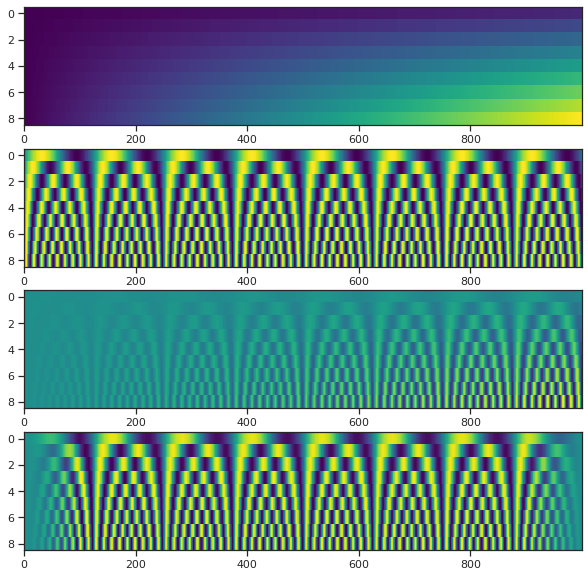

In [42]:
# Not that great
# It seems like we need to do rolling zscoring to capture local changes rather than over the entire trial

# Test signal
x_vec = np.linspace(0,50,1000)
x = np.array([x_vec*c for c in range(1,10)])
print(x.shape)
y = np.sin(x)
a = x/np.max(x)

y_a = a*y
fig,ax = plt.subplots(4,1,figsize=(10,10));
ax[0].imshow(x,aspect='auto')
ax[1].imshow(y,aspect='auto')
ax[2].imshow(y_a,aspect='auto')

def rolling_zscore(array, window_size):
    #array = y_a
    #window_size = 50
    out = np.zeros(array.shape)
    starts = np.arange((array.shape[-1] - window_size))
    inds = list(zip(starts,starts+window_size))
    for this_ind in inds:
        out[...,this_ind[0]:this_ind[1]] += stats.zscore(array[...,this_ind[0]:this_ind[1]],axis=-1)
    return out/window_size

ax[3].imshow(rolling_zscore(y_a,100),aspect='auto');

In [43]:
# # Not that great
# # It seems like we need to do rolling zscoring to capture local changes rather than over the entire trial
# # Gaussian weighted rolling z-score

# # Test signal
# x = np.linspace(0,50,1000)
# y = np.sin(x)
# change = 10
# a = x/np.max(x)

# y_a = a*y
# plt.plot(x,y,label = 'original')
# plt.plot(x,y_a,label = 'modified')

# # def rolling_zscore(vec, window_size):
# vec = y_a
# window_size = 50
# gauss_kern = scipy.signal.gaussian(window_size,window_size//6)
# plt.plot(x[:len(gauss_kern)],gauss_kern)
# plt.figure()
# plt.plot(x[:len(gauss_kern)],gauss_kern)
# out = np.zeros(vec.shape)
# starts = np.arange((vec.shape[-1] - window_size))
# inds = list(zip(starts,starts+window_size))
# for this_ind in tqdm(inds):
#     out[this_ind[0]:this_ind[1]] += (stats.zscore(y_a[this_ind[0]:this_ind[1]]))*gauss_kern
# out = out/window_size
# plt.figure()
# plt.plot(x,out,label = 'recovered')
# plt.legend()

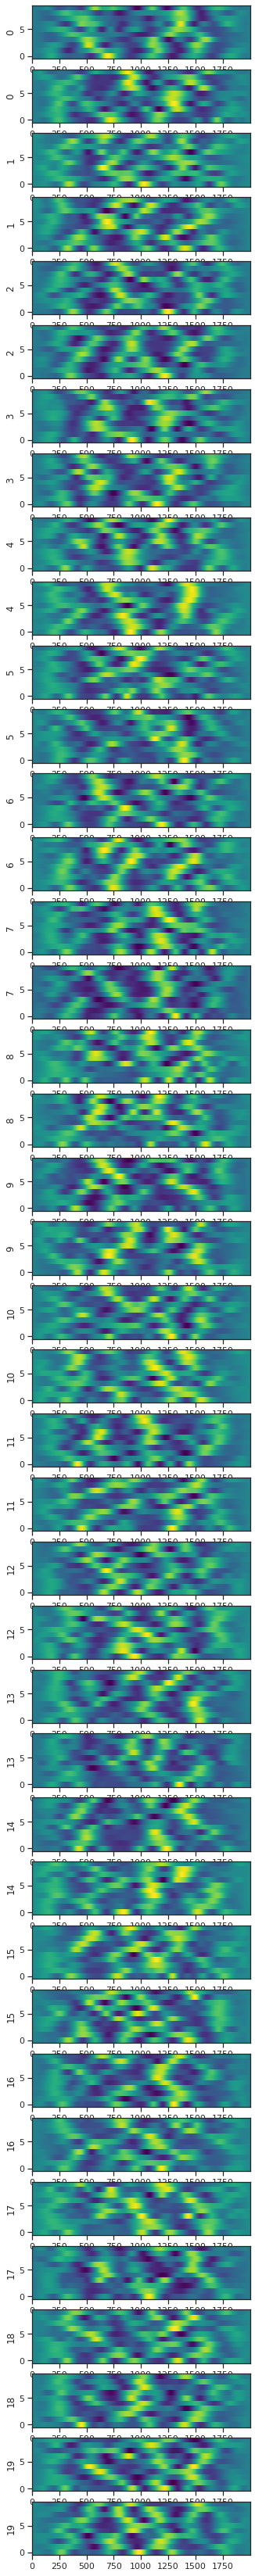

In [44]:
# Plot rolling zscored spectrograms
trial_count = 20
trial_inds = np.sort(np.random.choice(np.arange(clean_dat_binned_long.shape[0]),trial_count, replace = False))
rolling_size = 500

fig, ax = plt.subplots(trial_count*2, figsize = (5,3*trial_count))
for num,trial in enumerate(trial_inds):
#     ax[num*2].imshow(zscore_amp_long[trial],interpolation='nearest',aspect='auto',origin='lower')
#     ax[num*2+1].imshow(bla_zscore_amp_long[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num*2].imshow(rolling_zscore(clean_this_amp_long[trial],rolling_size),aspect='auto',origin='lower')
    ax[num*2+1].imshow(rolling_zscore(bla_amp_clean[trial],rolling_size),aspect='auto',origin='lower')
    ax[num*2].set_ylabel(num)
    ax[num*2+1].set_ylabel(num)
# ax[0,0].set_title('GC')
# ax[0,1].set_title('BLA')

In [45]:
# Perform rolling zscoring on spectrograms for both bla and gc
amp_array_long = np.swapaxes(dat.amplitude_array,1,2)
amp_array_long = np.reshape(amp_array_long,(-1,*amp_array_long.shape[2:]))
print(amp_array_long.shape)
channel = 0
gc_amp = amp_array_long[:,gc_electrodes[channel]]
gc_clean_amp = gc_amp[clean_trial_inds]
bla_amp = amp_array_long[:,bla_electrodes[channel]]
bla_clean_amp = bla_amp[clean_trial_inds]
print(gc_clean_amp.shape)

(120, 16, 10, 5000)
(102, 10, 5000)


In [46]:
window_size = 500
rzscore_gc_clean = np.array([rolling_zscore(x,window_size) for x in tqdm(gc_clean_amp)])
rzscore_bla_clean = np.array([rolling_zscore(x,window_size) for x in tqdm(bla_clean_amp)])
print(rzscore_gc_clean.shape)

100%|██████████| 102/102 [00:36<00:00,  2.78it/s]

(102, 10, 5000)


In [47]:
rzscore_gc_cut = rzscore_gc_clean[...,time_lims[0]:time_lims[1]]
rzscore_bla_cut = rzscore_bla_clean[...,time_lims[0]:time_lims[1]]

In [48]:
freq_vec = np.vectorize(np.int)(dat.freq_vec)[:-2]
freq_tick_labels = np.arange(freq_vec.min(),freq_vec.max(),3)
print(freq_tick_labels)
freq_ticks = np.linspace(0,len(freq_vec),len(freq_tick_labels))
print(freq_ticks)

[ 0  3  6  9 12]
[0. 2. 4. 6. 8.]


<Figure size 1080x360 with 0 Axes>

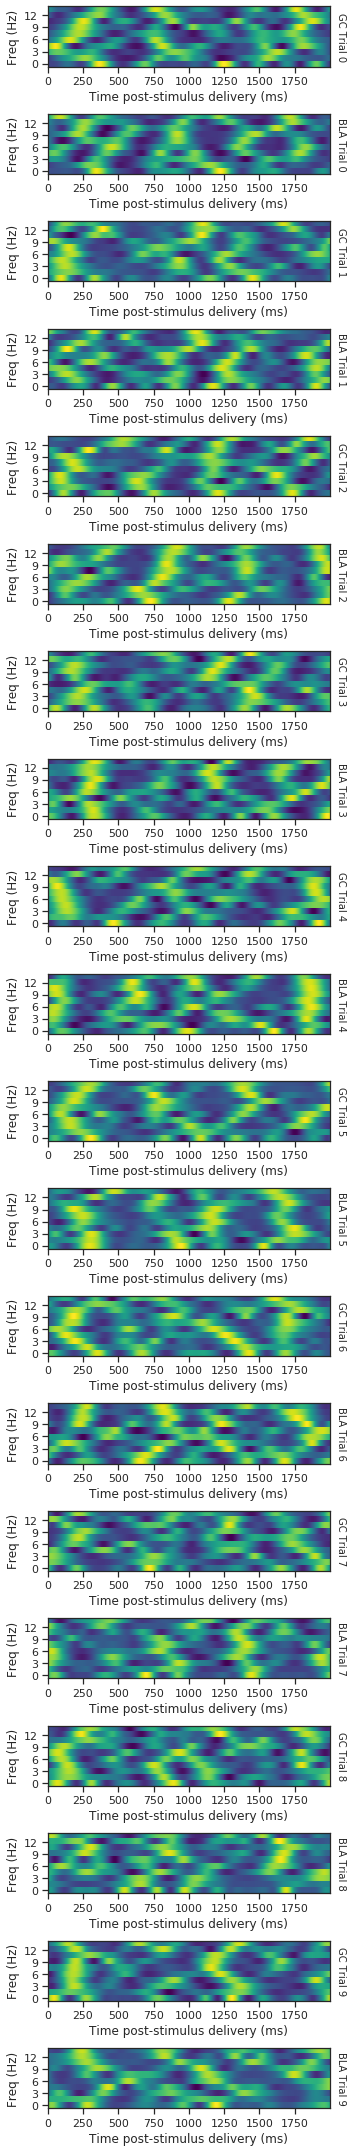

In [49]:
# Plot rolling zscored spectrograms
trial_count = 10

trial_inds = np.sort(np.random.choice(np.arange(clean_dat_binned_long.shape[0]),trial_count, replace = False))
plt.set_cmap('viridis')
fig, ax = plt.subplots(trial_count*2, figsize = (5,3*trial_count))
for num,trial in enumerate(trial_inds):
    ax[num*2].imshow(rzscore_gc_cut[trial],aspect='auto',origin='lower')
    ax[num*2+1].imshow(rzscore_bla_cut[trial],aspect='auto',origin='lower')
    
    ax[num*2].text(1.02,0.5,f'GC Trial {num}',rotation=270,verticalalignment='center', transform=ax[num*2].transAxes)
    ax[num*2+1].text(1.02,0.5,f'BLA Trial {num}',rotation=270,verticalalignment='center', transform=ax[num*2+1].transAxes)
    
    ax[num*2].set_yticks(ticks=freq_ticks)
    ax[num*2+1].set_yticks(ticks=freq_ticks)
    ax[num*2].set_yticklabels(labels = freq_tick_labels)
    ax[num*2+1].set_yticklabels(labels = freq_tick_labels)
    
    ax[num*2].set_ylabel('Freq (Hz)')
    ax[num*2+1].set_ylabel('Freq (Hz)')
    ax[num*2].set_xlabel('Time post-stimulus delivery (ms)')
    ax[num*2+1].set_xlabel('Time post-stimulus delivery (ms)')
plt.tight_layout()

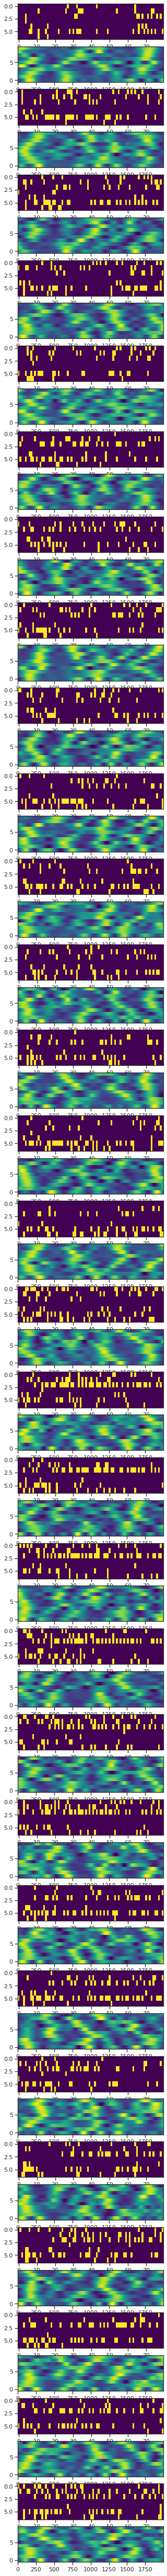

In [50]:
# Plot spikes with rolling zscored GC spectrograms
trial_count = 30
trial_inds = np.sort(np.random.choice(np.arange(clean_dat_binned_long.shape[0]),trial_count, replace = False))

fig, ax = plt.subplots(trial_count*2, figsize = (5,3*trial_count))
for num,trial in enumerate(trial_inds):
    ax[num*2].imshow(clean_dat_binned_long[trial]>0,aspect = 'auto')
    ax[num*2+1].imshow(rzscore_gc_cut[trial],interpolation='nearest',aspect='auto',origin='lower')
#     ax[num,2].imshow(reduced_stft_long[trial],interpolation='nearest',aspect='auto',origin='lower')

[86 57 72 46 92 96 63 97 77 36]
[84 35 17  7 62 13 14  2 51 40]
(102, 10)
(102, 10)
[ 0  2  4  6  8 10 12 14 16 18]
[ 0.          1.11111111  2.22222222  3.33333333  4.44444444  5.55555556
  6.66666667  7.77777778  8.88888889 10.        ]


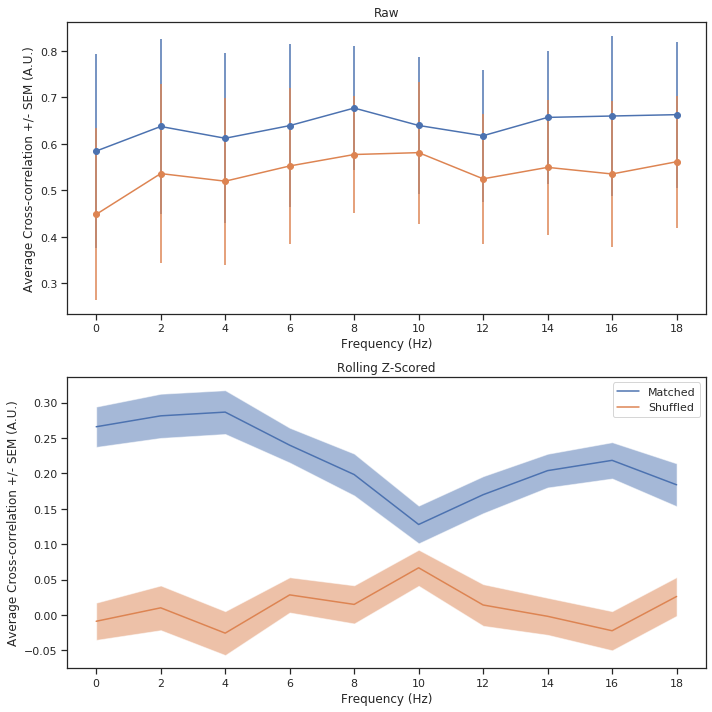

In [51]:
r_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(rzscore_gc_cut,rzscore_bla_cut)])
resamples = rzscore_gc_cut.shape[0]
r_inds1 = np.random.choice(np.arange(rzscore_gc_cut.shape[0]),size=resamples)
r_inds2 = np.random.choice(np.arange(rzscore_gc_cut.shape[0]),size=resamples)
print(inds1[:10])
print(inds2[:10])
r_shuffled_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) \
                            for v1,v2 in zip(rzscore_gc_cut[inds1],rzscore_bla_cut[inds2])])
r_mean_xcorrs = np.mean(r_xcorrs,axis=0)
r_std_xcorrs = np.std(r_xcorrs,axis=0)
r_sem_xcorrs = r_std_xcorrs/np.sqrt(r_xcorrs.shape[0])
r_mean_shuffle_xcorrs = np.mean(r_shuffled_xcorrs,axis=0)
r_std_shuffle_xcorrs = np.std(r_shuffled_xcorrs,axis=0)
r_sem_shuffle_xcorrs = r_std_shuffle_xcorrs/np.sqrt(r_shuffled_xcorrs.shape[0])

print(r_xcorrs.shape)
print(r_shuffled_xcorrs.shape)

freq_vec = np.vectorize(np.int)(dat.freq_vec)
freq_tick_labels = freq_vec
print(freq_tick_labels)
freq_ticks = np.linspace(0,len(freq_vec),len(freq_tick_labels))
print(freq_ticks)

fig,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].errorbar(dat.freq_vec,mean_xcorrs,std_xcorrs, label = 'Matched',marker = 'o')
ax[0].errorbar(dat.freq_vec,mean_shuffle_xcorrs,std_shuffle_xcorrs, label = 'Shuffled',marker = 'o')
ax[0].set_title('Raw')
ax[0].set_ylabel('Average Cross-correlation +/- SEM (A.U.)')
ax[0].set_xlabel('Frequency (Hz)')
# ax[1].errorbar(dat.freq_vec,r_mean_xcorrs,r_sem_xcorrs, label = 'Matched',marker = 'o')
# ax[1].errorbar(dat.freq_vec,r_mean_shuffle_xcorrs,r_sem_shuffle_xcorrs, label = 'Shuffled',marker = 'o')
ax[1].fill_between(dat.freq_vec,r_mean_xcorrs - r_sem_xcorrs, r_mean_xcorrs + r_sem_xcorrs,alpha = 0.5)
ax[1].fill_between(dat.freq_vec,r_mean_shuffle_xcorrs - r_sem_shuffle_xcorrs,r_mean_shuffle_xcorrs + r_sem_shuffle_xcorrs,alpha = 0.5)
ax[1].plot(dat.freq_vec,r_mean_xcorrs,label = 'Matched')
ax[1].plot(dat.freq_vec,r_mean_shuffle_xcorrs,label = 'Shuffled')
ax[1].set_title('Rolling Z-Scored')
ax[1].set_ylabel('Average Cross-correlation +/- SEM (A.U.)')
ax[1].set_xlabel('Frequency (Hz)')

ax[0].set_xticks(ticks=freq_tick_labels)
ax[1].set_xticks(ticks=freq_tick_labels)
ax[0].set_xticklabels(labels = freq_tick_labels)
ax[1].set_xticklabels(labels = freq_tick_labels)
plt.legend();
plt.tight_layout()

In [52]:
# Trials ranked by xcorrs from plotting
xcorr_sort = np.argsort(np.mean(r_xcorrs,axis=1))[::-1]

<Figure size 1080x360 with 0 Axes>

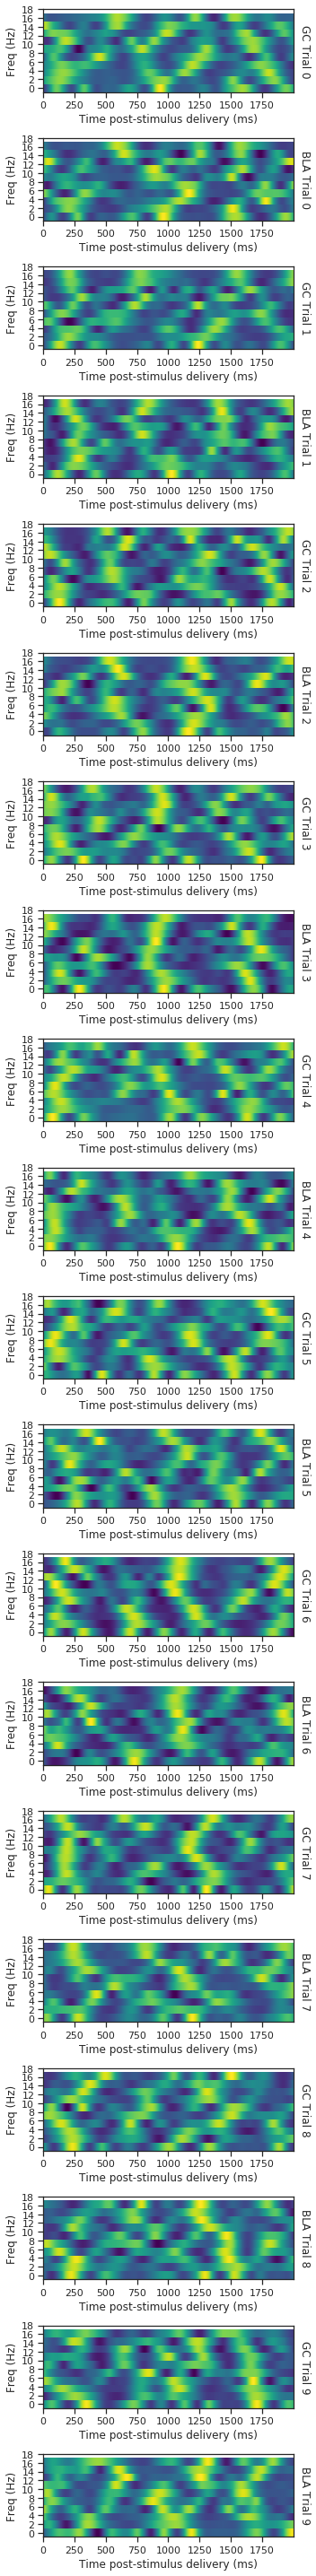

In [53]:
# Plot top 5 trials
# Plot rolling zscored spectrograms
trial_count = 10

trial_inds = xcorr_sort[:trial_count]
plt.set_cmap('viridis')
fig, ax = plt.subplots(trial_count*2, figsize = (5,4*trial_count))
for num,trial in enumerate(trial_inds):
    ax[num*2].imshow(rzscore_gc_cut[trial],aspect='auto',origin='lower')
    ax[num*2+1].imshow(rzscore_bla_cut[trial],aspect='auto',origin='lower')
    
    ax[num*2].text(1.02,0.5,f'GC Trial {num}',rotation=270,verticalalignment='center', transform=ax[num*2].transAxes, size='large')
    ax[num*2+1].text(1.02,0.5,f'BLA Trial {num}',rotation=270,verticalalignment='center', transform=ax[num*2+1].transAxes, size='large')
    
    ax[num*2].set_yticks(ticks=freq_ticks)
    ax[num*2+1].set_yticks(ticks=freq_ticks)
    ax[num*2].set_yticklabels(labels = freq_tick_labels)
    ax[num*2+1].set_yticklabels(labels = freq_tick_labels)
    
    ax[num*2].set_ylabel('Freq (Hz)')
    ax[num*2+1].set_ylabel('Freq (Hz)')
    ax[num*2].set_xlabel('Time post-stimulus delivery (ms)')
    ax[num*2+1].set_xlabel('Time post-stimulus delivery (ms)')
plt.tight_layout()

In [54]:
# Perform xcorr between pairs of channels within BLA and GC for reference

gc_amp2 = amp_array_long[:,gc_electrodes[channel2]]
gc_clean_amp2 = gc_amp2[clean_trial_inds]
bla_amp2 = amp_array_long[:,bla_electrodes[channel2]]
bla_clean_amp2 = bla_amp2[clean_trial_inds]

rzscore_gc_clean2 = np.array([rolling_zscore(x,window_size) for x in tqdm(gc_clean_amp2)])
rzscore_bla_clean2 = np.array([rolling_zscore(x,window_size) for x in tqdm(bla_clean_amp2)])

100%|██████████| 102/102 [00:37<00:00,  2.74it/s]


In [55]:
rzscore_gc_cut2 = rzscore_gc_clean2[...,time_lims[0]:time_lims[1]]
rzscore_bla_cut2 = rzscore_bla_clean2[...,time_lims[0]:time_lims[1]]
print(rzscore_gc_clean2.shape)
print(rzscore_gc_cut2.shape)

(102, 10, 5000)
(102, 10, 2000)


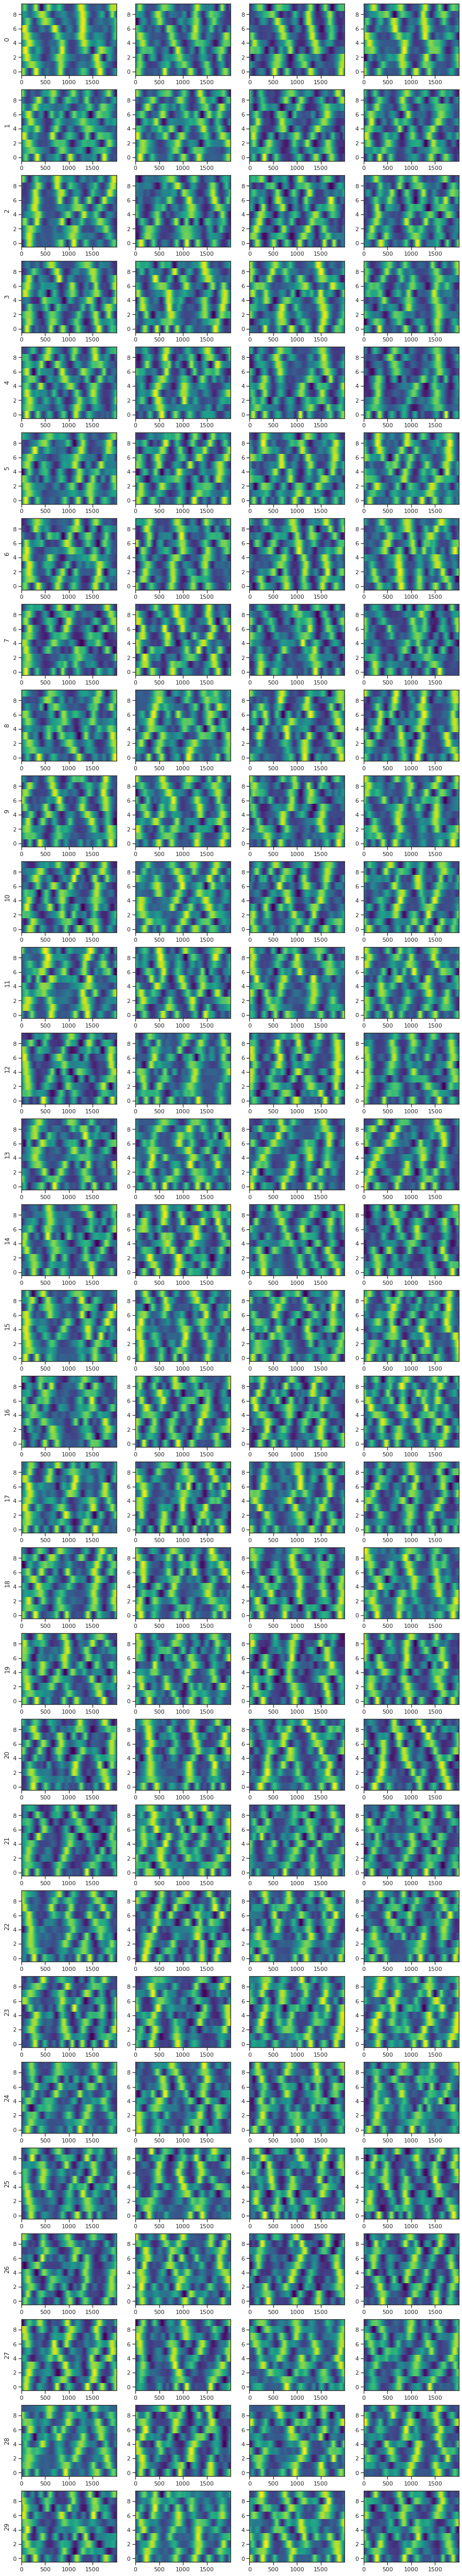

In [56]:
# Plot pairs of electrodes side by side to VISUALIZE similarity
# Overlay raster with CDF of switchpoints
trial_count = 30
trial_inds = np.sort(np.random.choice(np.arange(rzscore_gc_clean2.shape[0]),trial_count, replace = False))

fig, ax = plt.subplots(trial_count, 4, figsize = (15,3*trial_count))
for num,trial in enumerate(trial_inds):
    ax[num,0].imshow(rzscore_gc_cut[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,1].imshow(rzscore_gc_cut2[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,2].imshow(rzscore_bla_cut[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,3].imshow(rzscore_bla_cut2[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,0].set_ylabel(num)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


102
[ 6 63 70 41 92 13  1 16 92 80]
[37 67 71 92 89 88 48 43 23 70]
102
[33 91 73 41 80 70 25 12 63 53]
[ 96 100  38  31  17  19  33  56  49   9]
(10,)
(102, 10)
(102, 10)


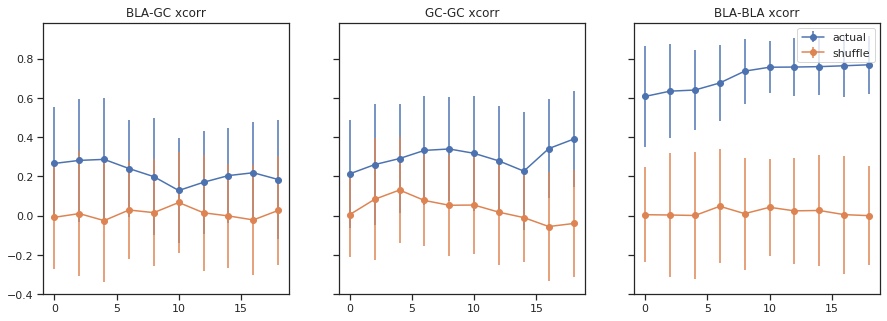

In [62]:
# Intra-GC xcorrs
r_gc_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(rzscore_gc_cut,rzscore_gc_cut2)])
resamples = rzscore_gc_cut.shape[0]
print(resamples)
inds1 = np.random.choice(np.arange(rzscore_gc_cut.shape[0]),size=resamples)
inds2 = np.random.choice(np.arange(rzscore_gc_cut.shape[0]),size=resamples)
print(inds1[:10])
print(inds2[:10])
r_gc_shuffled_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) \
                            for v1,v2 in zip(rzscore_gc_cut[inds1],rzscore_gc_cut2[inds2])])
r_gc_mean_xcorrs = np.mean(r_gc_xcorrs,axis=0)
r_gc_std_xcorrs = np.std(r_gc_xcorrs,axis=0)
r_gc_mean_shuffle_xcorrs = np.mean(r_gc_shuffled_xcorrs,axis=0)
r_gc_std_shuffle_xcorrs = np.std(r_gc_shuffled_xcorrs,axis=0)

# Intra-BLA xcorrs
r_bla_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(rzscore_bla_cut,rzscore_bla_cut2)])
resamples = rzscore_bla_cut.shape[0]
print(resamples)
inds1 = np.random.choice(np.arange(rzscore_bla_cut.shape[0]),size=resamples)
inds2 = np.random.choice(np.arange(rzscore_bla_cut.shape[0]),size=resamples)
print(inds1[:10])
print(inds2[:10])
r_bla_shuffled_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) \
                            for v1,v2 in zip(rzscore_bla_cut[inds1],rzscore_bla_cut2[inds2])])
r_bla_mean_xcorrs = np.mean(r_bla_xcorrs,axis=0)
r_bla_std_xcorrs = np.std(r_bla_xcorrs,axis=0)
r_bla_mean_shuffle_xcorrs = np.mean(r_bla_shuffled_xcorrs,axis=0)
r_bla_std_shuffle_xcorrs = np.std(r_bla_shuffled_xcorrs,axis=0)

# Plot cross-region with w/i region
fig,ax = plt.subplots(1,3,sharey=True, figsize = (15,5))
print(mean_xcorrs.shape)
ax[0].errorbar(dat.freq_vec,r_mean_xcorrs,r_std_xcorrs, label = 'actual',marker = 'o')
ax[0].errorbar(dat.freq_vec,r_mean_shuffle_xcorrs,r_std_shuffle_xcorrs, label = 'shuffle',marker = 'o')
ax[0].set_title('BLA-GC xcorr')
plt.legend();

ax[1].errorbar(dat.freq_vec,r_gc_mean_xcorrs,r_gc_std_xcorrs, label = 'actual',marker = 'o')
ax[1].errorbar(dat.freq_vec,r_gc_mean_shuffle_xcorrs,r_gc_std_shuffle_xcorrs, label = 'shuffle',marker = 'o')
ax[1].set_title('GC-GC xcorr')
plt.legend();


ax[2].errorbar(dat.freq_vec,r_bla_mean_xcorrs,r_bla_std_xcorrs, label = 'actual',marker = 'o')
ax[2].errorbar(dat.freq_vec,r_bla_mean_shuffle_xcorrs,r_bla_std_shuffle_xcorrs, label = 'shuffle',marker = 'o')
ax[2].set_title('BLA-BLA xcorr')
plt.legend();

print(gc_xcorrs.shape)
print(gc_shuffled_xcorrs.shape)



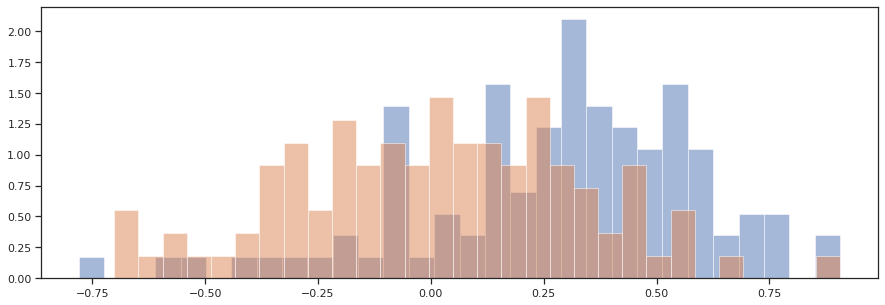

In [58]:
freq = 1
plt.hist(r_xcorrs[:,freq],30,alpha=0.5,density=True);
plt.hist(r_shuffled_xcorrs[:,freq],30,alpha=0.5,density=True);

In [59]:
# Perform Kruskal-Wallis to check for difference b/w actual and shuffle (in both raw and r-zscored)

# Raw
actual_inds = np.array(list(np.ndindex(xcorrs.shape)))
print(f'actual_inds_shape : {actual_inds.shape}')
xcorr_frame = pd.DataFrame({
                    'trials':actual_inds[:,0],
                    'freqs' : actual_inds[:,1],
                    'corr' : xcorrs.flatten(),
                    'class': ['actual']*actual_inds.shape[0]
})
shuffle_inds = np.array(list(np.ndindex(shuffled_xcorrs.shape)))
xcorr_frame = xcorr_frame.append(pd.DataFrame({
                    'trials': shuffle_inds[:,0],
                    'freqs' : shuffle_inds[:,1],
                    'corr' : shuffled_xcorrs.flatten(),
                    'class': ['shuffle']*shuffle_inds.shape[0]
}))
# print(xcorr_frame)
print(kruskal(data=xcorr_frame, dv='corr', between='class'))

## Also perform pairwise Mann-Whitney Test
mwu_tests = pd.concat([mwu(x, y, tail='two-sided') for x,y in zip(xcorrs.T, shuffled_xcorrs.T)])
print(mwu_tests)

actual_inds_shape : (1020, 2)
        Source  ddof1        H         p-unc
Kruskal  class      1  177.127  2.054305e-40
      U-val       tail         p-val    RBC   CLES
MWU  7132.5  two-sided  4.695527e-06 -0.371  0.686
MWU  6826.5  two-sided  1.170994e-04 -0.312  0.656
MWU  6688.5  two-sided  4.238266e-04 -0.286  0.643
MWU  6648.5  two-sided  6.037921e-04 -0.278  0.639
MWU  7331.5  two-sided  4.418609e-07 -0.409  0.705
MWU  6267.5  two-sided  1.153120e-02 -0.205  0.602
MWU  7040.5  two-sided  1.302246e-05 -0.353  0.677
MWU  7290.5  two-sided  7.318090e-07 -0.401  0.701
MWU  7506.5  two-sided  4.627053e-08 -0.443  0.721
MWU  7114.5  two-sided  5.753392e-06 -0.368  0.684


In [60]:
# ==============================================================#
# Rolling z-score
r_actual_inds = np.array(list(np.ndindex(r_xcorrs.shape)))
print(r_actual_inds.shape)
rz_xcorr_frame = pd.DataFrame({
                    'trials':r_actual_inds[:,0],
                    'freqs' : r_actual_inds[:,1],
                    'corr' : r_xcorrs.flatten(),
                    'class': ['actual']*r_actual_inds.shape[0]
})
r_shuffle_inds = np.array(list(np.ndindex(r_shuffled_xcorrs.shape)))
rz_xcorr_frame = rz_xcorr_frame.append(pd.DataFrame({
                    'trials': r_shuffle_inds[:,0],
                    'freqs' : r_shuffle_inds[:,1],
                    'corr' : r_shuffled_xcorrs.flatten(),
                    'class': ['shuffle']*r_shuffle_inds.shape[0]
}))
# print(rz_xcorr_frame)
print(kruskal(data=rz_xcorr_frame, dv='corr', between='class'))

## Also perform pairwise Mann-Whitney Test
mwu_tests = pd.concat([mwu(x, y, tail='two-sided') for x,y in zip(r_xcorrs.T, r_shuffled_xcorrs.T)])
print(mwu_tests)

(1020, 2)
        Source  ddof1        H         p-unc
Kruskal  class      1  244.642  3.823731e-55
      U-val       tail         p-val    RBC   CLES
MWU  7884.5  two-sided  1.995469e-10 -0.516  0.758
MWU  7706.5  two-sided  2.859377e-09 -0.481  0.741
MWU  7970.5  two-sided  5.179569e-11 -0.532  0.766
MWU  7515.5  two-sided  4.101535e-08 -0.445  0.722
MWU  7138.5  two-sided  4.386370e-06 -0.372  0.686
MWU  5983.5  two-sided  6.395009e-02 -0.150  0.575
MWU  6657.5  two-sided  5.579924e-04 -0.280  0.640
MWU  7595.5  two-sided  1.377336e-08 -0.460  0.730
MWU  7571.5  two-sided  1.917827e-08 -0.455  0.728
MWU  6733.5  two-sided  2.817529e-04 -0.294  0.647


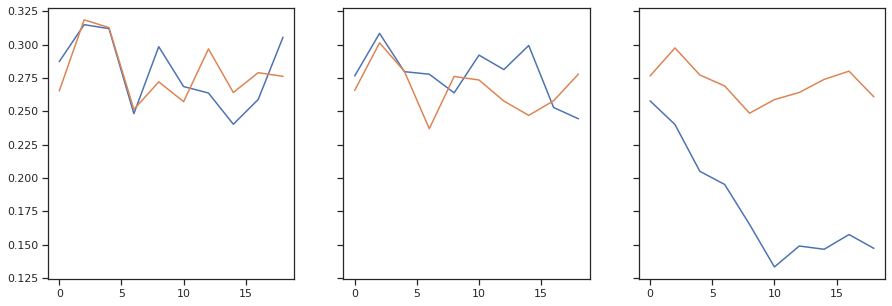

In [61]:
# Calculate effect-size of difference for each frequency
# This will allow us to plot effect size distributions for all 
# electrode pairs

# Plot variance to visualize how different they are for Cohen's D SD pooling
fig,ax = plt.subplots(1,3,sharey=True, figsize = (15,5))
ax[0].plot(dat.freq_vec,r_std_xcorrs)
ax[0].plot(dat.freq_vec,r_std_shuffle_xcorrs)

ax[1].plot(dat.freq_vec,r_gc_std_xcorrs)
ax[1].plot(dat.freq_vec,r_gc_std_shuffle_xcorrs)

ax[2].plot(dat.freq_vec,r_bla_std_xcorrs)
ax[2].plot(dat.freq_vec,r_bla_std_shuffle_xcorrs)

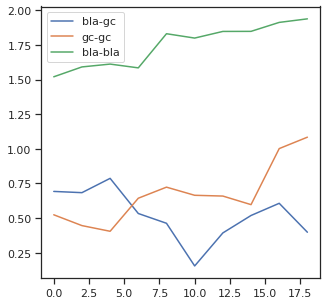

In [69]:
# We'll ignore testing variance for now
pooled_sd_xcorr = np.sqrt(np.mean(r_std_xcorrs**2 + r_std_shuffle_xcorrs**2))
pooled_gc_sd_xcorr = np.sqrt(np.mean(r_gc_std_xcorrs**2 + r_gc_std_shuffle_xcorrs**2))
pooled_bla_sd_xcorr = np.sqrt(np.mean(r_bla_std_xcorrs**2 + r_bla_std_shuffle_xcorrs**2))

xcorr_effect = np.abs(r_mean_xcorrs - r_mean_shuffle_xcorrs)/pooled_sd_xcorr
gc_xcorr_effect = np.abs(r_gc_mean_xcorrs - r_gc_mean_shuffle_xcorrs)/pooled_sd_xcorr
bla_xcorr_effect = np.abs(r_bla_mean_xcorrs - r_bla_mean_shuffle_xcorrs)/pooled_sd_xcorr

plt.figure(figsize=(5,5))
plt.plot(dat.freq_vec,xcorr_effect,label='bla-gc')
plt.plot(dat.freq_vec,gc_xcorr_effect,label='gc-gc')
plt.plot(dat.freq_vec,bla_xcorr_effect,label='bla-bla')
plt.legend();

In [ ]:
print(clean_this_amp_long.shape)
print(np.array(np.split(clean_this_amp_long,4,axis=-1)).shape)

In [ ]:
# Chop trial into 500ms bins and perform xcorr on each bin separately
splits = clean_this_amp_long.shape[-1]//500
gc_amp_split = np.array(np.split(clean_this_amp_long,splits,axis=-1))
bla_amp_split = np.array(np.split(bla_amp_clean,splits,axis=-1))
xcorrs = np.array([[norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(this_gc,this_bla)]\
                 for this_gc,this_bla in zip(gc_amp_split,bla_amp_split)])
print(xcorrs.shape)

resamples = 1000
inds1 = np.random.choice(np.arange(clean_this_amp_long.shape[0]),size=resamples)
inds2 = np.random.choice(np.arange(clean_this_amp_long.shape[0]),size=resamples)
print(inds1[:10])
print(inds2[:10])
shuffled_xcorrs = np.array([[norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(this_gc,this_bla)]\
                 for this_gc,this_bla in zip(gc_amp_split[:,inds1],bla_amp_split[:,inds2])])

mean_xcorrs = np.mean(xcorrs,axis=1)
std_xcorrs = np.std(xcorrs,axis=1)
mean_shuffle_xcorrs = np.mean(shuffled_xcorrs,axis=1)
std_shuffle_xcorrs = np.std(shuffled_xcorrs,axis=1)

fig,ax = plt.subplots(1,mean_xcorrs.shape[0],figsize = (15,5),sharey=True)
for this_bin in np.arange(mean_xcorrs.shape[0]):
    ax[this_bin].errorbar(dat.freq_vec,mean_xcorrs[this_bin],std_xcorrs[this_bin], label = 'actual',marker = 'o')
    ax[this_bin].errorbar(dat.freq_vec,mean_shuffle_xcorrs[this_bin],std_shuffle_xcorrs[this_bin], label = 'shuffle',marker = 'o')
plt.legend();

# Plot mean difference for each bin
mean_diff = mean_xcorrs - mean_shuffle_xcorrs
inds = np.array(list(np.ndindex(mean_diff.shape)))
mean_diff_frame = pd.DataFrame({
                    'bin' : inds[:,0],
                    'freq' : inds[:,1],
                    'diff' : mean_diff.flatten()
})
plt.figure()
g = sns.catplot(
    data=mean_diff_frame, kind="bar",
    x="bin", y="diff", hue="freq",
    ci="sd", palette="dark", alpha=.6, height=6)

# Anova on each bin
inds = np.array(list(np.ndindex(xcorrs.shape)))
xcorr_frame = pd.DataFrame({
                'bin' : inds[:,0],
                'trial' : inds[:,1],
                'freq' : inds[:,2],
                'corr' : xcorrs.flatten(),
                'class' : ['actual']*inds.shape[0]
})
shuffle_inds = np.array(list(np.ndindex(shuffled_xcorrs.shape)))
xcorr_frame = xcorr_frame.append(pd.DataFrame({
                'bin' : shuffle_inds[:,0],
                'trial' : shuffle_inds[:,1],
                'freq' : shuffle_inds[:,2],
                'corr' : shuffled_xcorrs.flatten(),
                'class' : ['shuffle']*shuffle_inds.shape[0]
}))

print(pd.concat([\
        kruskal(data=xcorr_frame.query(f'bin == {x}'), dv='corr', between='class')\
                for x in range(xcorrs.shape[0])]))

In [ ]:
# Do same for rolling-zscored data
# Chop trial into 500ms bins and perform xcorr on each bin separately
splits = rzscore_gc_cut.shape[-1]//500
r_gc_amp_split = np.array(np.split(rzscore_gc_cut,splits,axis=-1))
r_bla_amp_split = np.array(np.split(rzscore_bla_cut,splits,axis=-1))
r_xcorrs = np.array([[norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(this_gc,this_bla)]\
                 for this_gc,this_bla in zip(r_gc_amp_split,r_bla_amp_split)])
print(r_xcorrs.shape)

resamples = 1000
inds1 = np.random.choice(np.arange(rzscore_gc_cut.shape[0]),size=resamples)
inds2 = np.random.choice(np.arange(rzscore_gc_cut.shape[0]),size=resamples)
print(inds1[:10])
print(inds2[:10])
r_shuffled_xcorrs = np.array([[norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(this_gc,this_bla)]\
                 for this_gc,this_bla in zip(r_gc_amp_split[:,inds1],r_bla_amp_split[:,inds2])])

r_mean_xcorrs = np.mean(r_xcorrs,axis=1)
r_std_xcorrs = np.std(r_xcorrs,axis=1)
r_mean_shuffle_xcorrs = np.mean(r_shuffled_xcorrs,axis=1)
r_std_shuffle_xcorrs = np.std(r_shuffled_xcorrs,axis=1)

fig,ax = plt.subplots(1,r_mean_xcorrs.shape[0],figsize = (15,5),sharey=True)
for this_bin in np.arange(r_mean_xcorrs.shape[0]):
    ax[this_bin].errorbar(dat.freq_vec,r_mean_xcorrs[this_bin],r_std_xcorrs[this_bin], label = 'actual',marker = 'o')
    ax[this_bin].errorbar(dat.freq_vec,r_mean_shuffle_xcorrs[this_bin],r_std_shuffle_xcorrs[this_bin], label = 'shuffle',marker = 'o')
plt.legend();

# Plot mean difference for each bin
r_mean_diff = r_mean_xcorrs - r_mean_shuffle_xcorrs
r_inds = np.array(list(np.ndindex(r_mean_diff.shape)))
r_mean_diff_frame = pd.DataFrame({
                    'bin' : r_inds[:,0],
                    'freq' : r_inds[:,1],
                    'diff' : r_mean_diff.flatten()
})
plt.figure()
g = sns.catplot(
    data= r_mean_diff_frame, kind="bar",
    x="bin", y="diff", hue="freq",
    ci="sd", palette="dark", alpha=.6, height=6)

# Anova on each bin
r_inds = np.array(list(np.ndindex(r_xcorrs.shape)))
r_xcorr_frame = pd.DataFrame({
                'bin' : r_inds[:,0],
                'trial' : r_inds[:,1],
                'freq' : r_inds[:,2],
                'corr' : r_xcorrs.flatten(),
                'class' : ['actual']*r_inds.shape[0]
})
r_shuffle_inds = np.array(list(np.ndindex(shuffled_xcorrs.shape)))
r_xcorr_frame = r_xcorr_frame.append(pd.DataFrame({
                'bin' : r_shuffle_inds[:,0],
                'trial' : r_shuffle_inds[:,1],
                'freq' : r_shuffle_inds[:,2],
                'corr' : r_shuffled_xcorrs.flatten(),
                'class' : ['shuffle']*r_shuffle_inds.shape[0]
}))

print(pd.concat([\
        kruskal(data=r_xcorr_frame.query(f'bin == {x}'), dv='corr', between='class')\
                for x in range(r_xcorrs.shape[0])]))

## Changepoint Code

In [ ]:
states = 4
tastes = this_dat_binned.shape[0]
split_list = np.array_split(this_dat_binned,states,axis=-1)
# Cut all to the same size
min_val = min([x.shape[-1] for x in split_list])
split_array = np.array([x[...,:min_val] for x in split_list])
print(split_array.shape)
mean_vals = np.mean(split_array,axis=(2,-1)).swapaxes(0,1)
mean_vals += 0.01 # To avoid zero starting prob
print(mean_vals.shape) # Trials x nrns
# print(mean_vals)
mean_nrn_vals = np.mean(mean_vals,axis=(0,1))
print(mean_nrn_vals.shape) # Trials x nrns

In [362]:
idx = np.arange(this_dat_binned.shape[-1]) # Index
array_idx = np.broadcast_to(idx, dat_binned_long.shape)
idx_range = idx.max() - idx.min()
print(idx.min())
print(idx.max())
print(array_idx.shape)

0
79
(120, 7, 80)


In [522]:
even_switches = np.linspace(0,idx.max(),states+1)
even_switches_normal = even_switches/np.max(even_switches)
print(even_switches)
print(even_switches_normal[1:(states)])

[ 0.   19.75 39.5  59.25 79.  ]
[0.25 0.5  0.75]


(28,)
(4, 28)
(4, 4, 28)


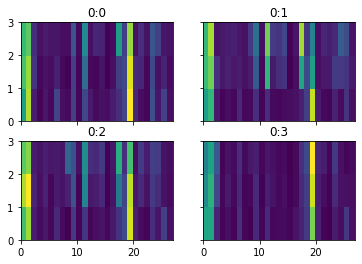

In [523]:
with pm.Model() as model:
    
    
    # SAME LAMBDAS ACROSS ALL TRIALS
    # Finite, but somewhere on the lower end, Beta prior
    # Shared hyperprior for single neuron (across tastes and states)
#     a_lambda = 2
#     b_lambda = 5
    # Priors for each neuron
    lambda_nrn = pm.Exponential('lambda_nrn',1/mean_nrn_vals, shape = (mean_vals.shape[-1]))
#     b_lambda = pm.HalfNormal('b_lambda',3, shape = (mean_vals.shape[-1]))
    
    # Priors for each state, derived from each neuron
    lambda_state = pm.Exponential('lambda_state',lambda_nrn, shape = (mean_vals.shape[1:]))
#     sig_lambda_state = pm.HalfNormal('sig_lambda_state',b_lambda, shape = (mean_vals.shape[1:]))
#     a_lambda_state = pm.HalfNormal('a_lambda_state',a_lambda, shape = (mean_vals.shape[1:]))
#     b_lambda_state = pm.HalfNormal('b_lambda_state',b_lambda, shape = (mean_vals.shape[1:]))
    
    lambda_latent = pm.Exponential('lambda', lambda_state[np.newaxis,:,:], testval = mean_vals, 
                            shape = (mean_vals.shape))

print(lambda_nrn.tag.test_value.shape)
print(lambda_state.tag.test_value.shape)
print(lambda_latent.tag.test_value.shape)

visualize.firing_overview(lambda_latent.tag.test_value,cmap='viridis');

In [524]:
trial_num = array_idx.shape[0]

with model:
    
    # INDEPENDENT TAU FOR EVERY TRIAL
    a = pm.HalfNormal('a_tau', 3., shape = states - 1)
    b = pm.HalfNormal('b_tau', 3., shape = states - 1)
    
    # Stack produces states x trials --> That gets transposed to trials x states and gets sorted along states (axis=-1)
    # Sort should work the same way as the Ordered transform --> see rv_sort_test.ipynb

    tau_latent = pm.Beta('tau_latent', a, b, 
                           shape = (trial_num, states-1),
                        testval = tt.tile(even_switches_normal[1:(states)],(array_idx.shape[0],1))).sort(axis=-1)
       
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)

print(tau.tag.test_value.shape)
tau_test_value = tau.tag.test_value

(120, 3)


In [525]:
print(array_idx.shape)

(120, 28, 80)


In [526]:
with model:
    
    # Assign lambdas to time_bin indices using sigmoids centered on switchpoints
    # Refer to https://www.desmos.com/calculator/yisbydv2cq
    
    weight_1_stack = tt.nnet.sigmoid(array_idx - tau[:,0][...,np.newaxis,np.newaxis])
    weight_2_stack = tt.nnet.sigmoid(array_idx - tau[:,1][...,np.newaxis,np.newaxis])
    weight_3_stack = tt.nnet.sigmoid(array_idx - tau[:,2][...,np.newaxis,np.newaxis])
    #weight_4_stack = tt.nnet.sigmoid(array_idx - tau[:,3][...,np.newaxis,np.newaxis])

#     tau = tau[...,np.newaxis,np.newaxis]
#     weight_stack = tt.nnet.sigmoid(tt.tile(array_idx,(states-1,1,1,1)).swapaxes(0,1) - tau)
    
print(weight_1_stack.tag.test_value.shape)
print(lambda_latent.tag.test_value.shape)

(120, 28, 80)
(4, 4, 28)


In [527]:
weight_1_test =  weight_1_stack.tag.test_value[0]
lambda_latent_test = lambda_latent.tag.test_value[0]
print(weight_1_test.shape)
print(lambda_latent_test.shape)

(28, 80)
(4, 28)


In [528]:
with model:
    
    taste_label = np.repeat([0,1,2,3],30)
    
#     # 3 states
#     lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[taste_label,0][:,:,np.newaxis]) + \
#                 np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[taste_label][:,1][:,:,np.newaxis]) + \
#                 np.multiply(weight_2_stack, lambda_latent[taste_label,2][:,:,np.newaxis])
    
    # 4 states
    lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[taste_label,0][:,:,np.newaxis]) + \
                np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[taste_label][:,1][:,:,np.newaxis]) + \
                np.multiply(weight_2_stack * (1 - weight_3_stack), lambda_latent[taste_label][:,2][:,:,np.newaxis]) + \
                np.multiply(weight_3_stack, lambda_latent[taste_label,3][:,:,np.newaxis])
    
#     # 5 states
#     lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[taste_label,0][:,:,np.newaxis]) + \
#                 np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[taste_label][:,1][:,:,np.newaxis]) + \
#                 np.multiply(weight_2_stack * (1 - weight_3_stack), lambda_latent[taste_label][:,2][:,:,np.newaxis]) +\
#                 np.multiply(weight_3_stack * (1 - weight_4_stack), lambda_latent[taste_label][:,3][:,:,np.newaxis])+ \
#                 np.multiply(weight_4_stack, lambda_latent[taste_label,4][:,:,np.newaxis])

#     lambda_latent_temp = lambda_latent[taste_label,:,:,np.newaxis]
#     print(lambda_latent.tag.test_value.shape)
#     print(lambda_latent_temp.tag.test_value.shape)
    
#     lambda_ = np.multiply(1 - weight_stack[:,0], lambda_latent_temp[:,0]) + \
#                 np.multiply(weight_stack[:,0] * (1 - weight_stack[:,1]), lambda_latent_temp[:,1]) + \
#                 np.multiply(weight_stack[:,1] * (1 - weight_stack[:,2]), lambda_latent_temp[:,2]) + \
#                 np.multiply(weight_stack[:,2], lambda_latent_temp[:,3])

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


(120, 28, 80)
(120, 28, 80)


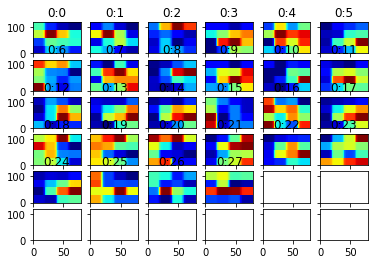

<Figure size 432x288 with 0 Axes>

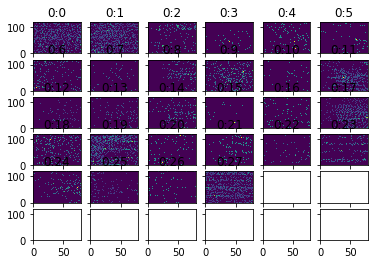

In [529]:
# print(taste_label)
print(weight_1_stack.tag.test_value.shape)
print(lambda_.tag.test_value.shape)
visualize.firing_overview(lambda_.tag.test_value.swapaxes(0,1));
plt.figure()
visualize.firing_overview(dat_binned_long.swapaxes(0,1),cmap='viridis');

In [530]:
# Using Bernoullo likelihood for count data
with model:
    observation = pm.Poisson("obs", lambda_, observed=dat_binned_long)

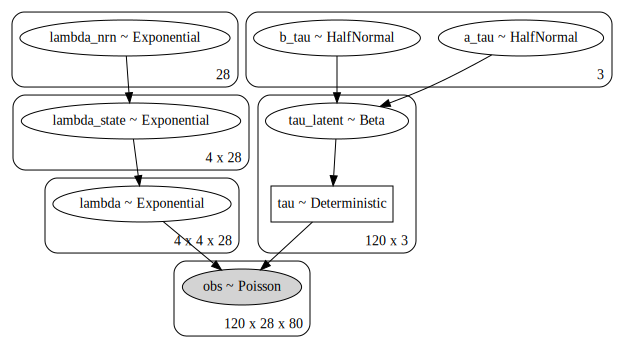

In [531]:
pm.model_to_graphviz(model)

In [532]:
fit = 40000
samples = 20000
model_save_dir = os.path.join(data_dir,'saved_models',f'vi_{states}_states')
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
model_dump_path = os.path.join(model_save_dir,f'dump_{fit}fit_{samples}samples_time{time_lims}_bin{bin_width}.pkl')
if os.path.exists(model_dump_path):
    print('Trace loaded from cache')
    with open(model_dump_path, 'rb') as buff:
        data = pickle.load(buff)
    trace = data['trace']
else:
    with model:
        #step= pm.Metropolis()
        #step= pm.NUTS()
        #trace = pm.sample(100, tune=10,
        #                  step = step,
        #                  chains = 30, cores = 30)
        inference = pm.ADVI('full-rank')
        approx = pm.fit(n=fit, method=inference)
        trace = approx.sample(draws=samples)

    print('Dumping trace to cache')
    with open(model_dump_path, 'wb') as buff:
        pickle.dump({'trace': trace}, buff)

  0%|          | 0/40000 [00:00<?, ?it/s]/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 98,718: 100%|██████████| 40000/40000 [16:20<00:00, 40.81it/s]   
Finished [100%]: Average Loss = 98,718


Dumping trace to cache


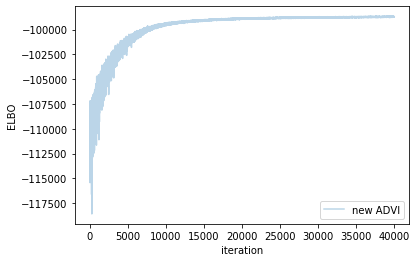

In [533]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
#plt.plot(approx.hist, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [534]:
print(trace['tau_latent'].shape)

(20000, 120, 3)


In [535]:
# pm.autocorrplot(trace['tau_latent'][:,0,0]);
# pm.autocorrplot(trace['tau_latent'][::20,0,0]);

In [536]:
trace['lambda'].shape

(20000, 4, 4, 28)

In [537]:
# pm.forestplot(trace[::100], var_names = ['a_tau','b_tau']);
# pm.forestplot(trace[::100], var_names = ['lambda_nrn']);
# # pm.forestplot(trace[::100], var_names = 'tau');
# pm.forestplot(trace[::100], var_names = ['lambda_state']);
# pm.forestplot(trace[::100], var_names = ['lambda']);

# pm.forestplot(trace, var_names = ['a_tau','b_tau']);
# pm.forestplot(trace, var_names = 'tau');
# pm.forestplot(trace, var_names = ['a_lambda','b_lambda']);
# pm.forestplot(trace, var_names = ['a_lambda_state','b_lambda_state']);
# pm.forestplot(trace, var_names = ['lambda']);

In [538]:
lambda_stack = trace['lambda'].swapaxes(0,1)
tau_samples = trace['tau']
print(tau_samples.shape)
print(lambda_stack.shape)

(20000, 120, 3)
(4, 20000, 4, 28)


In [539]:
mean_tau = np.mean(tau_samples, axis=0)
mean_lambda = np.mean(lambda_stack,axis=1).swapaxes(1,2)
print(mean_tau.shape)
print(mean_lambda.shape)

(120, 3)
(4, 28, 4)


(4, 28, 4)
(4, 28, 4)


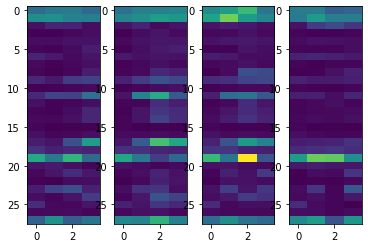

<Figure size 432x288 with 0 Axes>

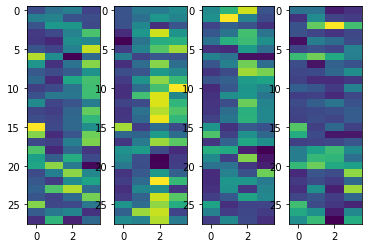

In [540]:
fig,ax = plt.subplots(1,mean_lambda.shape[0]);
for this_ax, this_dat in zip(ax, mean_lambda):
    this_ax.imshow(this_dat, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis',
                                      vmin = 0, vmax = np.max(mean_lambda,axis=None))

plt.figure();
zscore_mean_lambda = np.array([stats.zscore(nrn,axis=None) for nrn in mean_lambda.swapaxes(0,1)]).swapaxes(0,1)
print(mean_lambda.shape)
print(zscore_mean_lambda.shape)
fig,ax = plt.subplots(1,mean_lambda.shape[0]);
for this_ax, this_dat in zip(ax, zscore_mean_lambda):
    this_ax.imshow(this_dat, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis')



In [541]:
# # Chunk subplots by state
# swapped_mean_lambda = mean_lambda.swapaxes(0,-1)
# print(swapped_mean_lambda.shape)
# fig,ax = plt.subplots(1,swapped_mean_lambda.shape[0]);
# for num,(this_ax, this_dat) in enumerate(zip(ax, swapped_mean_lambda)):
#     this_ax.imshow(stats.zscore(this_dat,axis=-1), interpolation = 'nearest', aspect = 'auto', cmap = 'viridis')
#     this_ax.set_title('State {}'.format(num))

In [542]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)
ppc['obs'].shape

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
  0%|          | 0/2000 [00:00<?, ?it/s]/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100%|██████████| 2000/2000 [00:42<00:00, 46.64it/s]


(2000, 120, 28, 80)

In [543]:
mean_ppc = np.mean(ppc['obs'],axis=0)
# std_ppc = np.std(ppc['obs'],axis=0)
print(mean_ppc.shape)

(120, 28, 80)


In [544]:
mean_mean_tau = np.mean(tau_samples,axis=(0,1))
mean_mean_ppc = np.mean(mean_ppc,axis=1)
zscore_mean_mean_ppc = np.array([stats.zscore(nrn,axis=None) for nrn in mean_mean_ppc.swapaxes(0,1)]).swapaxes(0,1)
print(mean_mean_tau.shape)
print(mean_mean_ppc.shape)
print(zscore_mean_mean_ppc.shape)

(3,)
(120, 80)
(120, 80)


(2400000, 3)


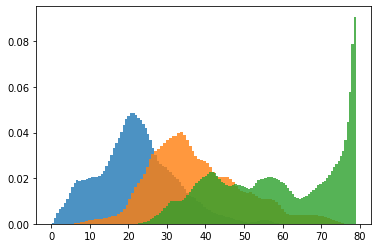

In [545]:
long_tau_samples = tau_samples.reshape((-1, tau_samples.shape[-1]))
print(long_tau_samples.shape)
for switch in range(long_tau_samples.shape[-1]):
     plt.hist(long_tau_samples[...,switch],bins = 100, density = True,alpha = 0.8)
    
# for this_ax in ax[-1,:]:
#     this_ax.set_xticks(np.arange(0,len(binned_t_vec),tick_interval));
#     this_ax.set_xticklabels(binned_t_vec[::tick_interval],rotation='vertical');

In [546]:
zscore_mean_ppc = stats.zscore(mean_ppc, axis=(-1))
print(zscore_mean_ppc.shape)

(120, 28, 80)


In [547]:
plot_spikes = dat_binned_long>0

(4, 15, 30, 10, 5000)
(120, 10, 2000)
[ 931.10373248 1137.69192687 1983.07170024]
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
(120, 3)
(2000,)


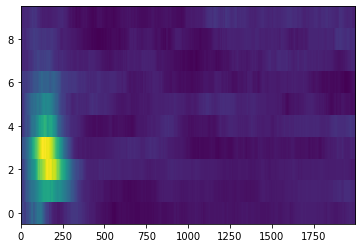

In [562]:
channel = 7
stft_cut = stats.zscore(dat.amplitude_array[:,gc_electrodes],axis=-1)
print(stft_cut.shape)
stft_cut = stft_cut[:,channel,...,time_lims[0]:time_lims[1]]
stft_cut = np.reshape(stft_cut,(-1,*stft_cut.shape[2:]))
print(stft_cut.shape)
stft_ticks = dat.time_vec[time_lims[0]:time_lims[1]]*1000
stft_tick_inds = np.arange(0,len(stft_ticks),250)
visualize.imshow(np.median(stft_cut,axis=0))

mean_tau_stft = (mean_tau/np.max(mean_tau,axis=None))*stft_cut.shape[-1]
print(mean_tau_stft[0])
print(dat.freq_vec)
print(mean_tau_stft.shape)
print(stft_ticks.shape)

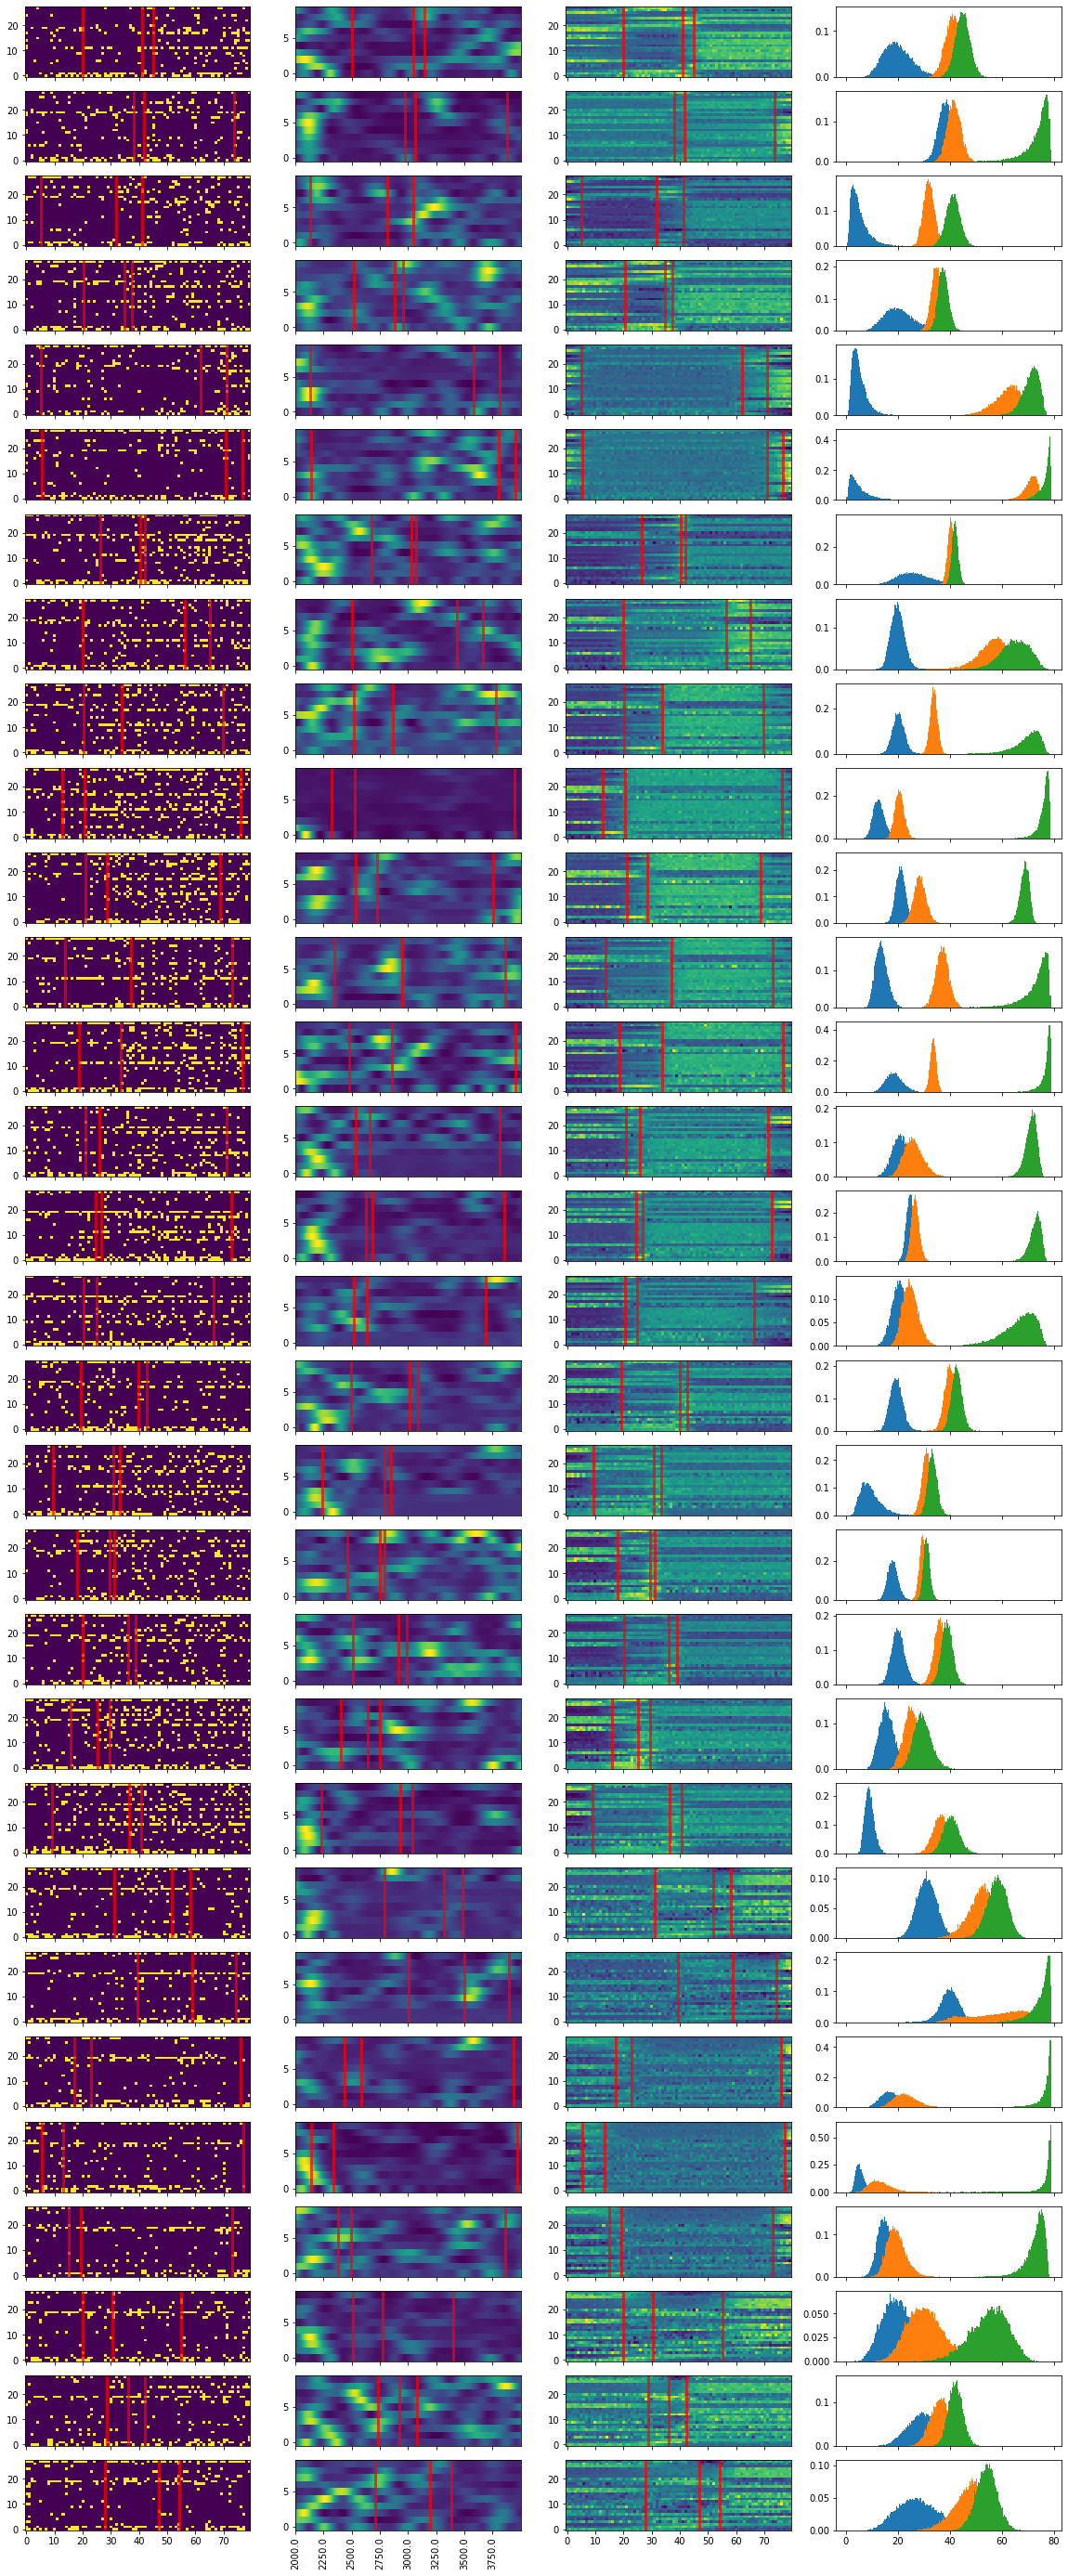

In [563]:
# Overlay raster with CDF of switchpoints
trial_count = 30
tick_interval = 5
trial_inds = np.sort(np.random.choice(np.arange(mean_ppc.shape[0]),trial_count, replace = False))

fig, ax = plt.subplots(trial_count,4,sharex='col', figsize = (20,50))
for num,trial in enumerate(trial_inds):
    ax[num,0].imshow(plot_spikes[trial],aspect='auto',origin='lower')
    ax[num,1].imshow(stft_cut[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,-2].imshow(zscore_mean_ppc[trial], aspect='auto',origin='lower')
    ax[num,0].vlines(mean_tau[trial],-0.5,zscore_mean_ppc.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    ax[num,1].vlines(mean_tau_stft[trial],-0.5,stft_cut.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    ax[num,-2].vlines(mean_tau[trial],-0.5,zscore_mean_ppc.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    
    ax[num,1].set_xticks(stft_tick_inds)
    ax[num,1].set_xticklabels(stft_ticks[stft_tick_inds],rotation='vertical')

    for state in range(tau_samples.shape[-1]):
        ax[num,-1].hist(tau_samples[:,trial,state], bins = 100, density = True)

# for col in [0,2,3]:
#     plt.sca(ax[-1,col])
#     plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
#     plt.xlim(0,len(binned_t_vec))


In [488]:
# Find trials where the mean tau for one changepoint is outside the 95% interval for other taus 
print(mean_tau.shape)
print(tau_samples.shape)
# # pre-compute ecdf for each tau for each trial
# ecdf_list = [[np.histogram(this_tau,200) for this_tau in taus] for taus in tqdm(np.moveaxis(tau_samples,0,-1))]
# print(ecdf_list[0][0])
percentile_array = np.zeros((*mean_tau.shape,mean_tau.shape[-1]))
for trial_num, (this_mean_tau, this_tau_dist) in enumerate(zip(mean_tau, np.moveaxis(tau_samples,0,-1))):
    for tau1_val, this_tau in enumerate(this_mean_tau):
        for tau2_val, this_dist in enumerate(this_tau_dist):
            percentile_array[trial_num, tau1_val, tau2_val] = percentileofscore(this_dist, this_tau)

(120, 3)
(20000, 120, 3)


In [489]:
# trial = 15
# print(percentile_array.shape)
# print(percentile_array[trial])
# for state in range(tau_samples.shape[-1]):
#     plt.hist(tau_samples[:,trial,state],100)

In [490]:
# Visually, threshold of <1 percentile seems compelling
# Find all trials where all the upper triangular elements are <1
# and lower triangular elements are >99
lower_thresh = 1
upper_thresh = 100 - lower_thresh
# print(percentile_array[trial][np.triu_indices(states-1,1)])
# print(sum(percentile_array[trial][np.triu_indices(states-1,1)] < lower_thresh)==(states-1))
# print(percentile_array[trial][np.tril_indices(states-1,-1)])
# print(sum(percentile_array[trial][np.tril_indices(states-1,1)] > upper_thresh)==(states-1))

# x = percentile_array[trial]
# print(sum(x[np.triu_indices(states-1,1)] < lower_thresh)==(states-1))
# print(sum(x[np.triu_indices(states-1,1)] > upper_thresh)==(states-1))
good_trial_list = np.where([sum(x[np.triu_indices(states-1,1)] < lower_thresh)==(states-1) \
                  and sum(x[np.tril_indices(states-1,1)] > upper_thresh)==(states-1) \
                  for x in percentile_array])[0]
print(len(good_trial_list))
print(good_trial_list)

15
[  7  19  24  28  41  52  58  64  66  88 104 106 107 110 111]


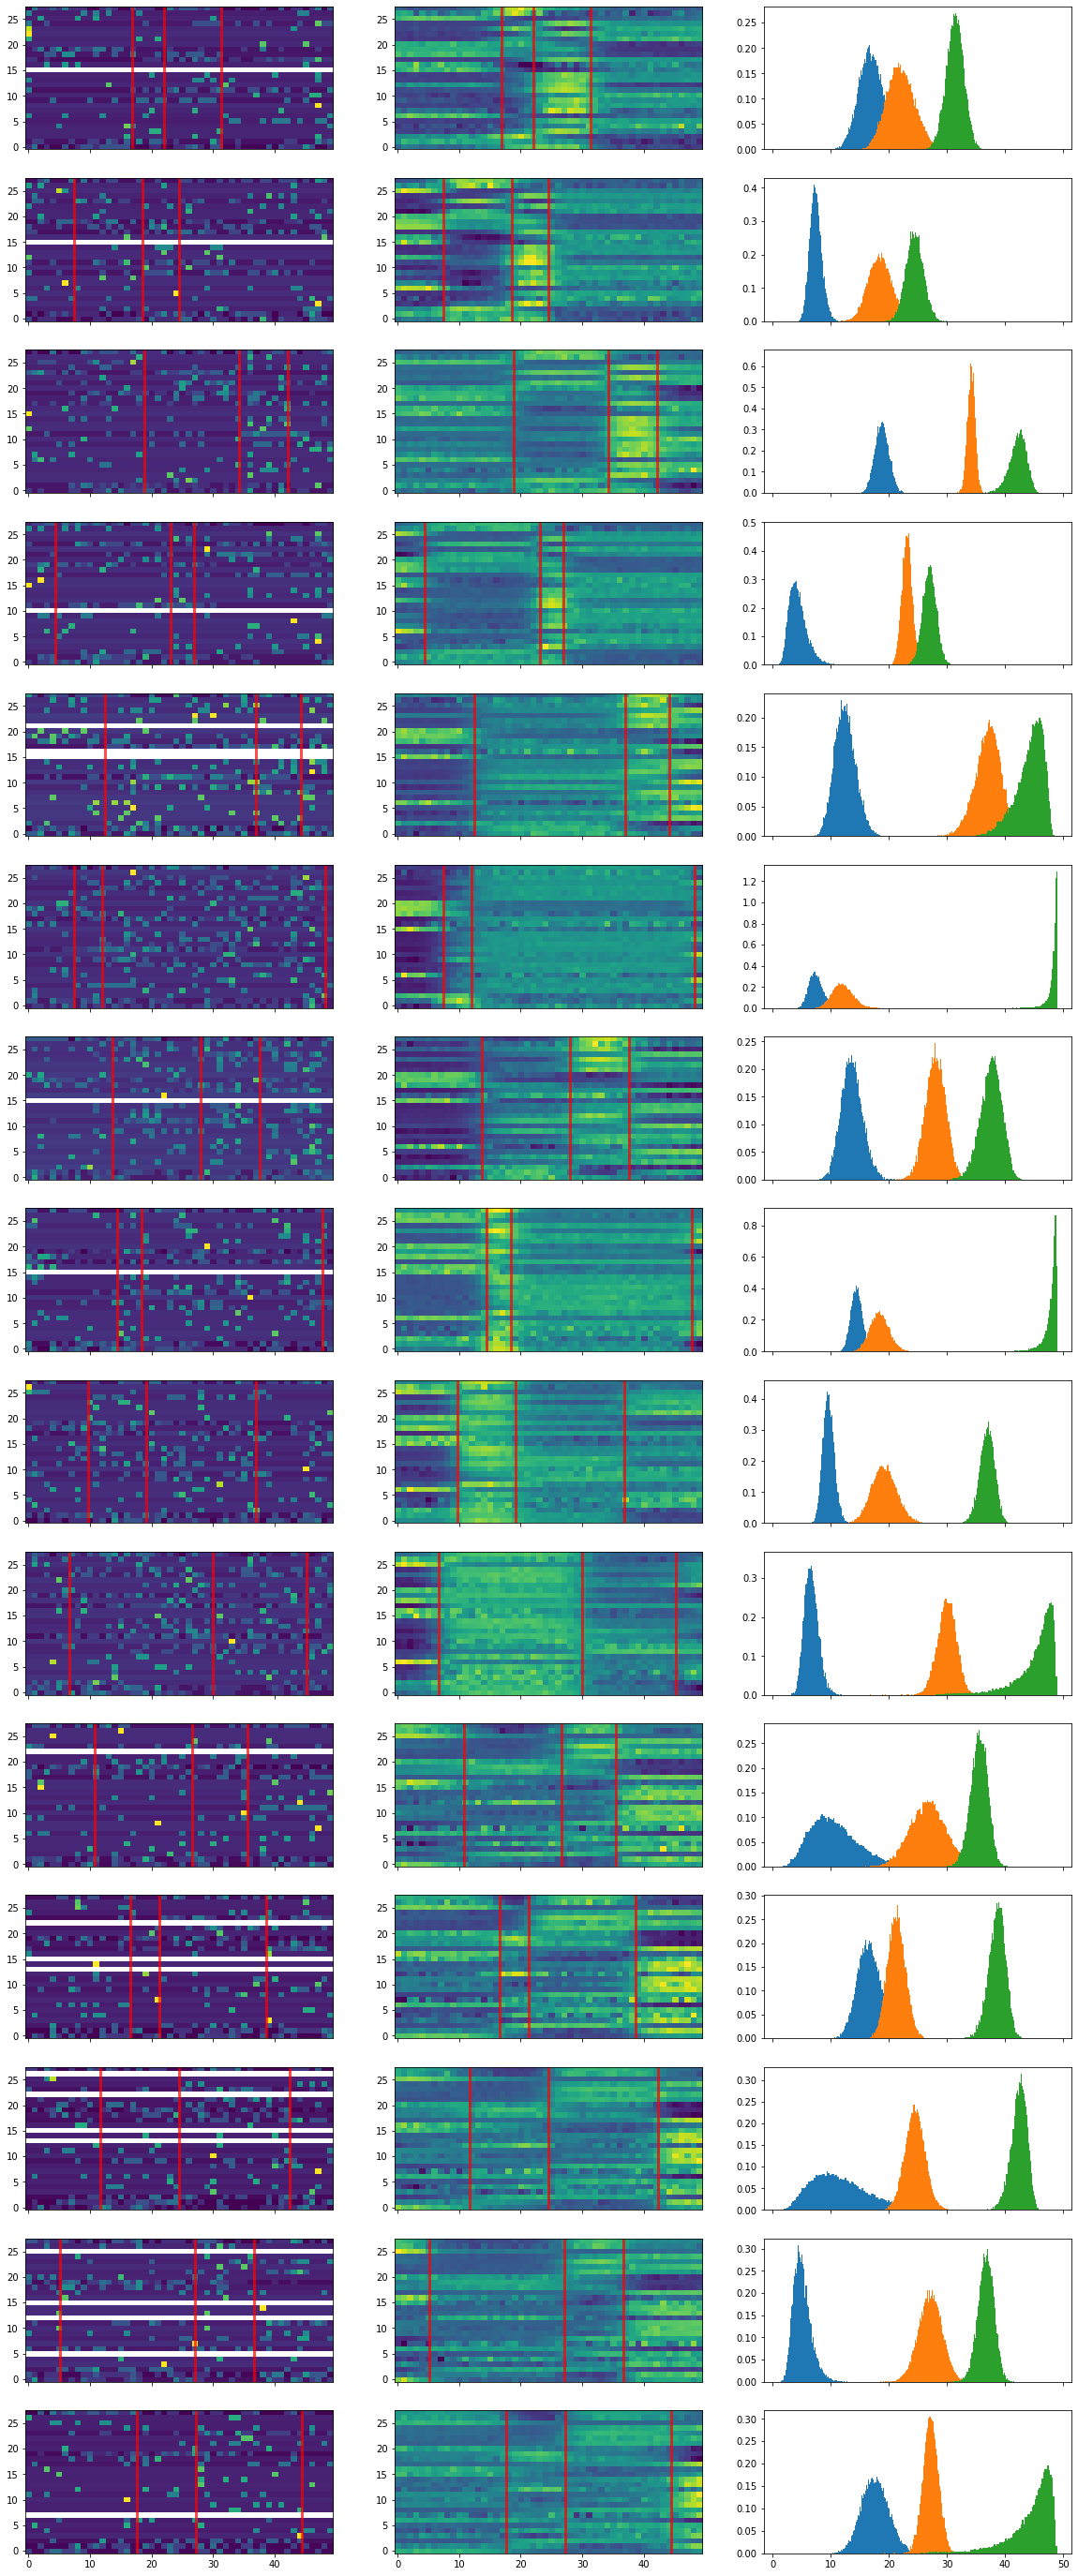

In [491]:
# Plot only good trials
# Overlay raster with CDF of switchpoints
trial_count = np.min((30, len(good_trial_list)))
tick_interval = 5
trial_inds = np.sort(np.random.choice(good_trial_list,trial_count, replace = False))

fig, ax = plt.subplots(trial_count,3,sharex='col', figsize = (20,50))
for num,trial in enumerate(trial_inds):
    ax[num,0].imshow(stats.zscore(plot_spikes[trial],axis=-1),aspect='auto',origin='lower')
    #ax[num,1].imshow(stft_cut[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,1].imshow(zscore_mean_ppc[trial], aspect='auto',origin='lower')
    ax[num,0].vlines(mean_tau[trial],-0.5,zscore_mean_ppc.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    #ax[num,1].vlines(mean_tau_stft[trial],-0.5,stft_cut.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    ax[num,1].vlines(mean_tau[trial],-0.5,zscore_mean_ppc.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    
    #ax[num,1].set_xticks(stft_tick_inds)
    #ax[num,1].set_xticklabels(stft_ticks[stft_tick_inds],rotation='vertical')

    for state in range(tau_samples.shape[-1]):
        ax[num,2].hist(tau_samples[:,trial,state], bins = 100, density = True)

# for col in [0,2,3]:
#     plt.sca(ax[-1,col])
#     plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
#     plt.xlim(0,len(binned_t_vec))


In [492]:
# See whether you can extract differences in valve opening times from transition points
taste_tau = []
for taste in sorted(set(taste_label)):
    taste_tau.append(mean_tau[taste_label==taste])
taste_tau = np.array(taste_tau)
print(taste_tau.shape)
taste_mean_tau = np.mean(taste_tau,axis=1)
taste_mean_time = taste_mean_tau[:,0]*bin_width
print(taste_mean_time - np.min(taste_mean_time))

(4, 30, 3)
[88.55553511 60.50166528 45.92942634  0.        ]


# Firing Rate Alignment

In [361]:
# # Well...that was garbage
# # Align BAKS firing rates and use them for correlation
# visualize.imshow(dat.all_normalized_firing[17])
# plt.figure();
# plt.plot(np.mean(dat.all_normalized_firing[17],axis=0))
# print(dat.all_normalized_firing.shape)

IndexError: index 17 is out of bounds for axis 0 with size 17

In [426]:
taste_dat.shape[-1]//dat.all_normalized_firing.shape[-1]

25

In [493]:
# For visualization
# Take firing around each transition and stack it together
# Perform alignemnt on uncut data (0-7000 ms) so there are no missing parts
# (in case a changepoint is too close to the start or the end)
# Before and after alignment
window_radius_time = 1000 # ms
# firing_bin_width = (dat.firing_rate_params['baks_resolution'] * 1000)
firing_bin_width = (taste_dat.shape[-1] // dat.all_normalized_firing.shape[-1])
print(firing_bin_width)
window_radius_bins = int(window_radius_time//firing_bin_width)
print(window_radius_bins)

# To translate the changepoints according to the start of the whole trial
# and convert them to firing_rate bins
mean_tau_adj = ((mean_tau + (time_lims[0]//bin_width))*bin_width)/firing_bin_width

# Convert tau to interegers
int_mean_tau = np.vectorize(np.int)(mean_tau_adj)

firing_long = dat.all_normalized_firing.swapaxes(0,1)
print(firing_long.shape)
print(int_mean_tau.shape)

25
40
(120, 35, 271)
(120, 3)


In [494]:
# Make time vector for plots
t_align = np.arange(-window_radius_time,window_radius_time,firing_bin_width)

In [495]:
# Take entire radius if available or whatever there is otherwise
# Iterate over changepoints and trials
# trials x neuron x switches x window_diameter
# Initiated with -1 to make sure gaps are visible
aligned_firing = np.ones((*firing_long.shape[:2],mean_tau.shape[-1],window_radius_bins*2))*-1
print(aligned_firing.shape)

(120, 35, 3, 80)


In [496]:
# Spikes aligned to trial-specific transitions
for trial in range(firing_long.shape[0]):
    for switch in range(mean_tau.shape[-1]):
        
        # Check whether we can pick out a window
        lower_bound = (int_mean_tau[trial,switch] - window_radius_bins)
        fin_lower_bound = lower_bound * (lower_bound > 0)
        upper_bound = (int_mean_tau[trial,switch] + window_radius_bins)
        fin_upper_bound = upper_bound * (upper_bound < firing_long.shape[-1]) + \
                                            firing_long.shape[-1] * (upper_bound > firing_long.shape[-1])

        # Done this way so all windows can be accomodated whether they are of the expected size or not
        lower_window = firing_long[trial,:,fin_lower_bound:int_mean_tau[trial,switch]]
        upper_window = firing_long[trial,:,int_mean_tau[trial,switch]:fin_upper_bound]
        #If window is smaller than the expected size, put it in centered on transition
        aligned_firing[trial,:,switch,(window_radius_bins - lower_window.shape[-1]):window_radius_bins] = lower_window
        aligned_firing[trial,:,switch,window_radius_bins:(window_radius_bins + upper_window.shape[-1])] = upper_window

In [497]:
# Spikes aligned to average transitions
unaligned_firing = np.ones((*firing_long.shape[:2],mean_tau.shape[-1],window_radius_bins*2))*-1
print(unaligned_firing.shape)
int_unaligned_tau = np.vectorize(np.int)(np.mean(mean_tau_adj,axis=0))
# Spikes aligned to trial-specific transitions
for switch in range(int_unaligned_tau.shape[-1]):

    # Check whether we can pick out a window
    lower_bound = (int_unaligned_tau[switch] - window_radius_bins)
    fin_lower_bound = lower_bound * (lower_bound > 0)
    upper_bound = (int_unaligned_tau[switch] + window_radius_bins)
    fin_upper_bound = upper_bound * (upper_bound < firing_long.shape[-1]) + \
                                        firing_long.shape[-1] * (upper_bound > firing_long.shape[-1])

    # Done this way so all windows can be accomodated whether they are of the expected size or not
    lower_window = firing_long[:,:,fin_lower_bound:int_unaligned_tau[switch]]
    upper_window = firing_long[:,:,int_unaligned_tau[switch]:fin_upper_bound]
    #If window is smaller than the expected size, put it in centered on transition
    unaligned_firing[:,:,switch,(window_radius_bins - lower_window.shape[-1]):window_radius_bins] = lower_window
    unaligned_firing[:,:,switch,window_radius_bins:(window_radius_bins + upper_window.shape[-1])] = upper_window

(120, 35, 3, 80)


In [498]:
# break down aligned_spikes by taste
aligned_list = []
for taste in sorted(set(taste_label)):
    aligned_list.append(aligned_spikes[taste_label==taste])
taste_aligned_spikes = np.array(aligned_list)
print(taste_aligned_spikes.shape)

(4, 30, 18, 3, 60)


(35, 3, 120, 80)


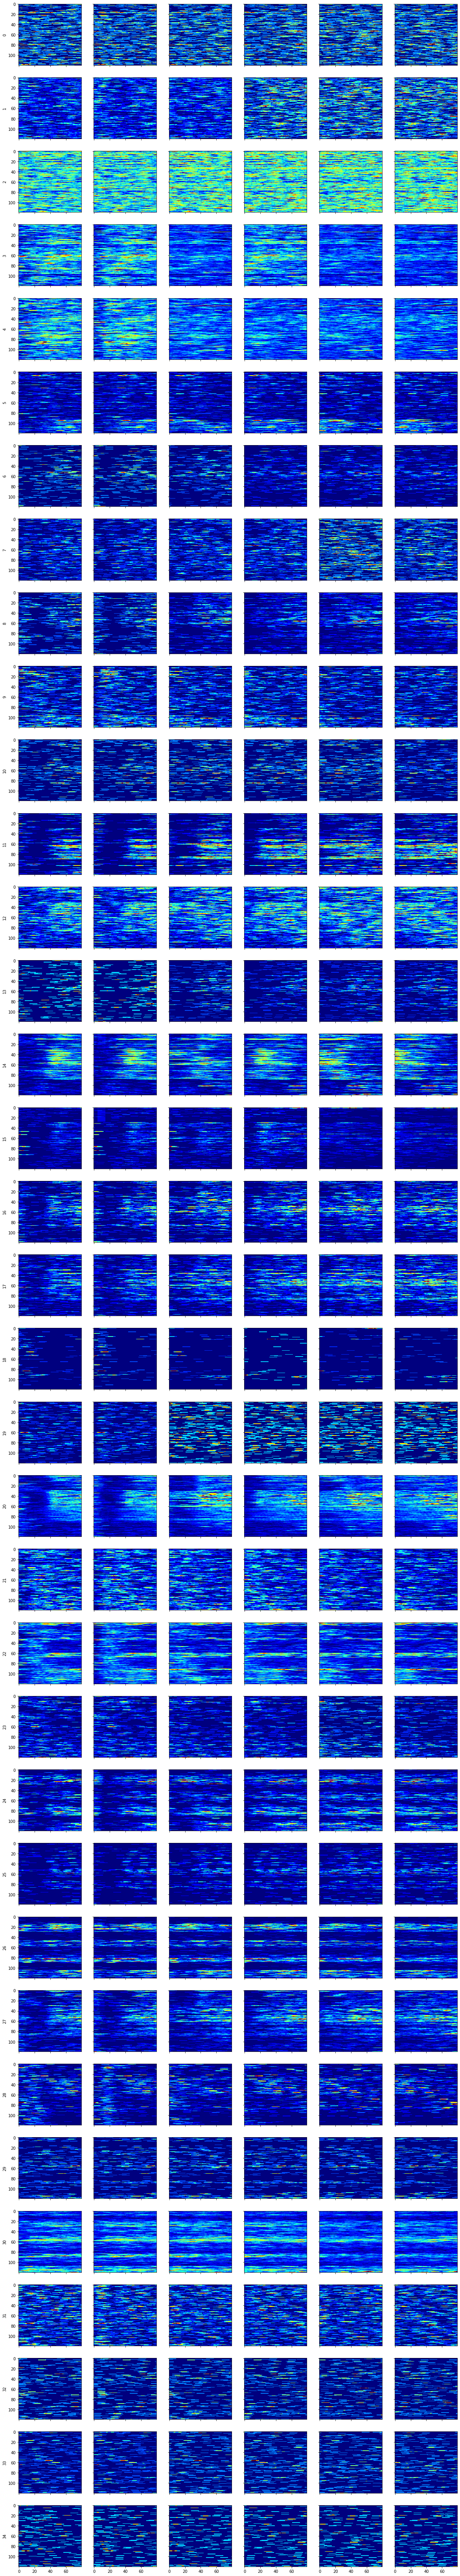

In [499]:
plot_dat_aligned = np.moveaxis(aligned_firing,0,2)
plot_dat_unaligned = np.moveaxis(unaligned_firing,0,2)
print(plot_dat_aligned.shape)

fig, ax = plt.subplots(plot_dat_aligned.shape[0],plot_dat_aligned.shape[1]*2,
                      sharex=True, sharey=True, figsize=(20,120))
iters = np.ndindex(plot_dat_aligned.shape[:2])
for this_iter in iters:
    #spikes = np.where(plot_dat[this_iter])
    #this_ax.scatter(spikes[1],spikes[0],s=2,alpha=0.7,marker = "|")
    ax[this_iter[0],2*this_iter[1]].imshow(plot_dat_aligned[this_iter],aspect='auto',cmap='jet')
    ax[this_iter[0],(2*this_iter[1])+1].imshow(plot_dat_unaligned[this_iter],aspect='auto',cmap='jet')
    
for num,this_ax in enumerate(ax[:,0].flatten()):
    this_ax.set_ylabel(num)
    

(35, 3, 80)
(18, 3, 60)


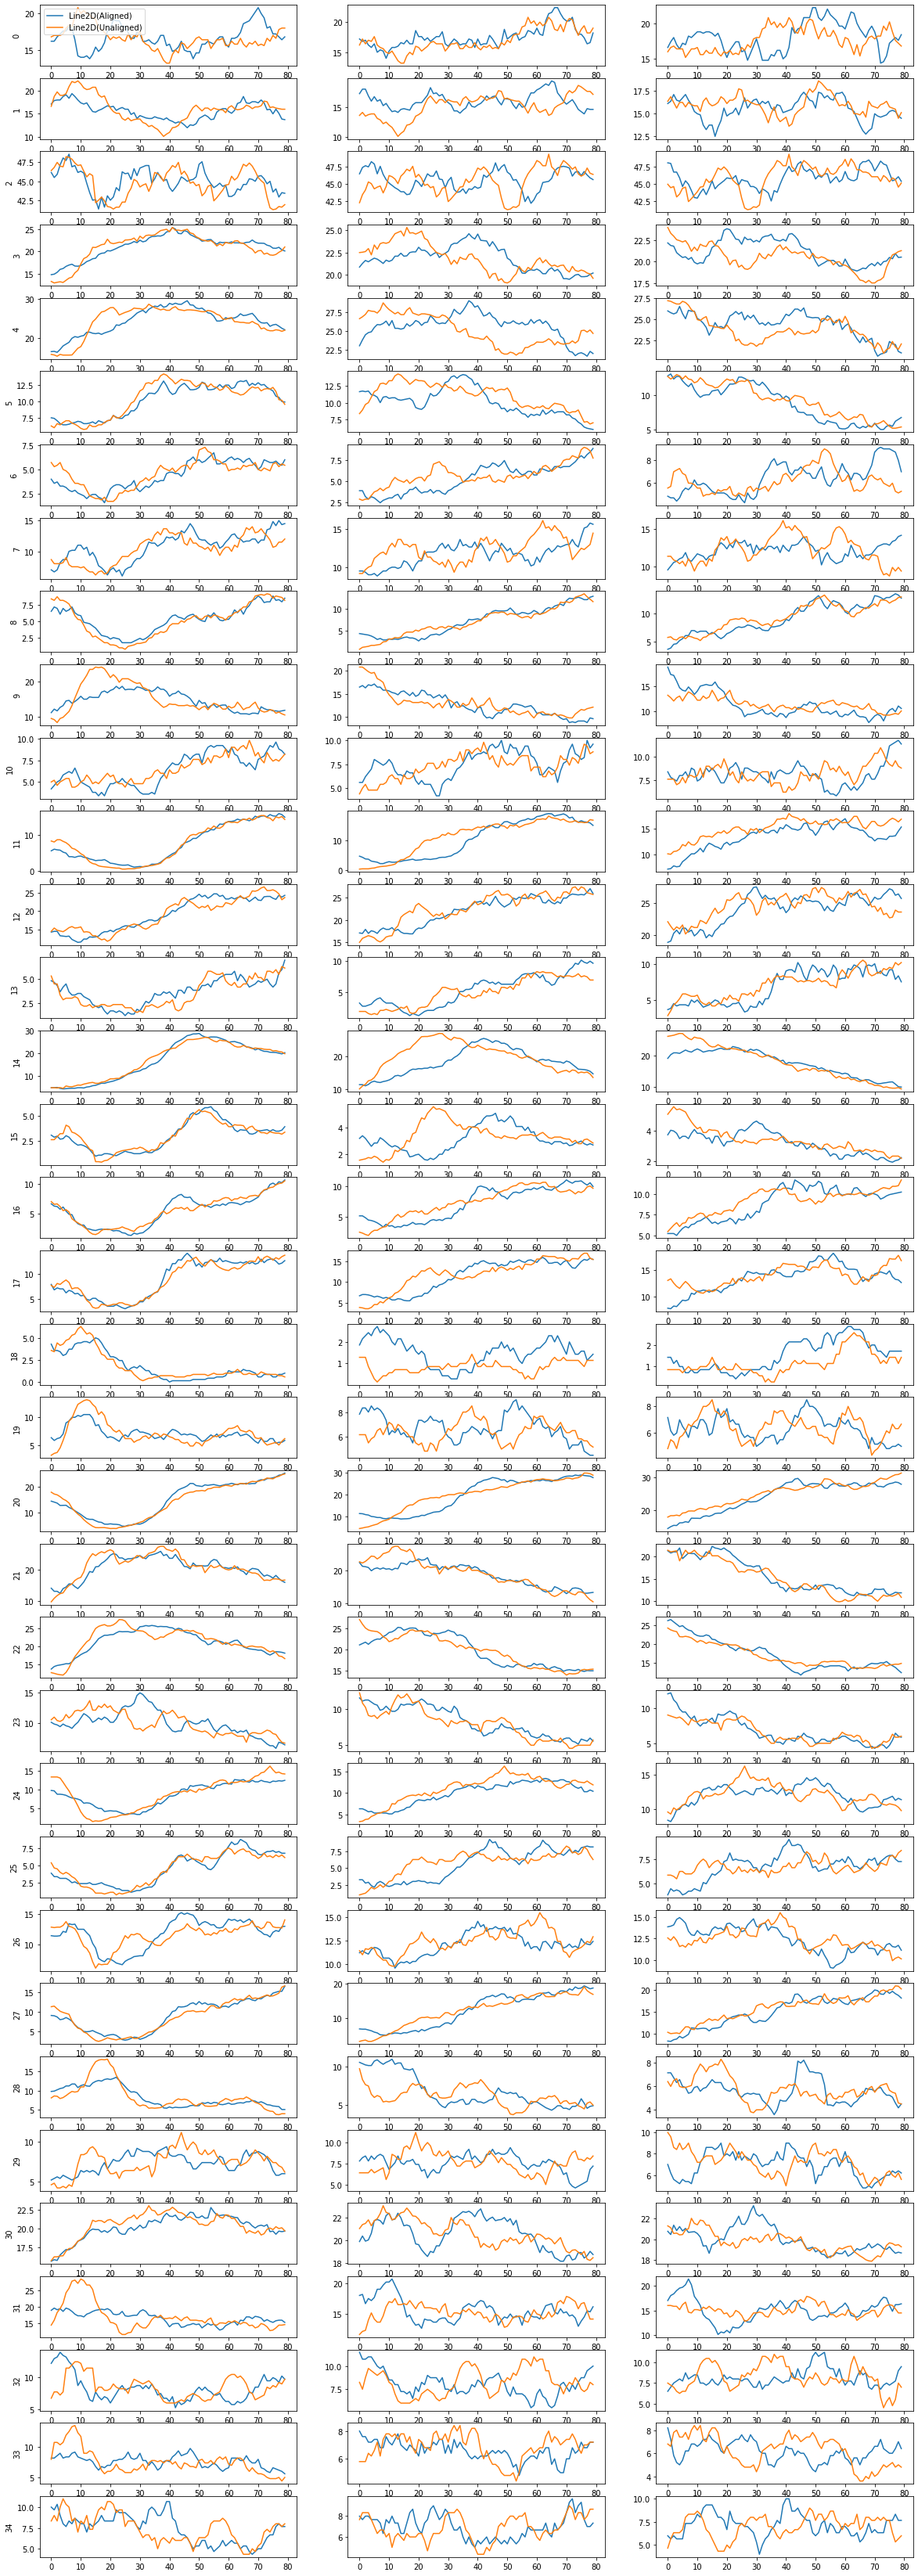

In [500]:
## Compare mean aligned psth (across all tastes) to mean psth at mean changepoint time
sum_aligned_firing = np.sum(plot_dat_aligned,axis=2)
sum_unaligned_firing = np.sum(plot_dat_unaligned,axis=2)
print(sum_aligned_firing.shape)
print(sum_unaligned_spikes.shape)
fig, ax = plt.subplots(sum_aligned_firing.shape[0],sum_aligned_firing.shape[1],
                      figsize = (20,60))
iters = np.ndindex(ax.shape)
for this_iter,this_ax in zip(iters,ax.flatten()):
    this_ax.plot(sum_aligned_firing[this_iter])
    this_ax.plot(sum_unaligned_firing[this_iter])
for num,this_ax in enumerate(ax[:,0].flatten()):
    this_ax.set_ylabel(num)
plt.sca(ax[0,0])
plt.legend([Line2D([0],[0],label = 'Aligned',color='blue'), 
            Line2D([0],[0],label = 'Unaligned', color = 'orange')],
          loc = 'upper left');

In [501]:
pal_vec = np.repeat(pal_rankings,plot_dat_aligned.shape[2]//len(pal_rankings))
aligned_dat_for_corr = np.moveaxis(plot_dat_aligned,-2,-1)
print(aligned_dat_for_corr.shape)
aligned_inds = list(np.ndindex(aligned_dat_for_corr.shape[:-1]))
aligned_spearman = np.zeros(aligned_dat_for_corr.shape[:-1])
for this_ind in aligned_inds:
    aligned_spearman[this_ind] = spearmanr(aligned_dat_for_corr[this_ind], pal_vec)[0]

print(aligned_spearman.shape)
# mean_aligned_spearman_r = np.abs(np.nanmean(aligned_spearman,axis=0))
mean_aligned_spearman_r = np.nanmean(np.abs(aligned_spearman),axis=0)

# Perform Fisher's Z transform for averaging and then revert
# z_aligned_spearman_r = np.arctanh(aligned_spearman)
# mean_z_aligned_spearman_r = np.mean(z_aligned_spearman_r,axis=0)
# mean_aligned_spearman_r = np.tanh(mean_z_aligned_spearman_r)
# print(mean_aligned_spearman_r.shape)

(35, 3, 80, 120)
(35, 3, 80)


In [502]:
unaligned_dat_for_corr = np.moveaxis(plot_dat_unaligned,-2,-1)
unaligned_inds = list(np.ndindex(aligned_dat_for_corr.shape[:-1]))
unaligned_spearman = np.zeros(unaligned_dat_for_corr.shape[:-1])
for this_ind in aligned_inds:
    unaligned_spearman[this_ind] = spearmanr(unaligned_dat_for_corr[this_ind], pal_vec)[0]

print(unaligned_spearman.shape)
# mean_unaligned_spearman_r = np.abs(np.nanmean(unaligned_spearman,axis=0))
mean_unaligned_spearman_r = np.nanmean(np.abs(unaligned_spearman),axis=0)

(35, 3, 80)


In [503]:
print(mean_aligned_spearman_r.shape)

(3, 80)


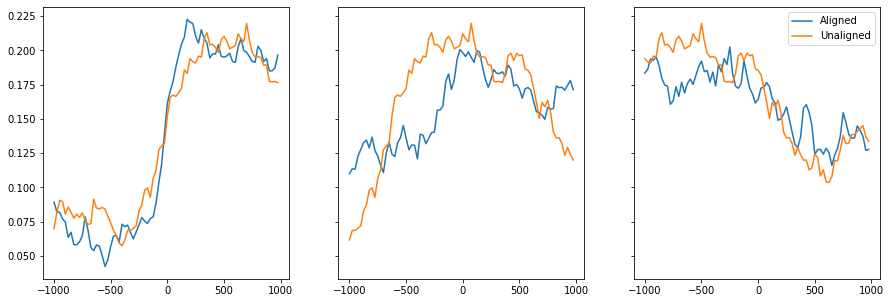

In [504]:
fig, ax = plt.subplots(1,states-1, figsize=(15,5), sharey = True)
for change in range(states-1):
    ax[change].plot(t_align, mean_aligned_spearman_r[change],label = 'Aligned')
    ax[change].plot(t_align, mean_unaligned_spearman_r[change], label = 'Unaligned')
plt.legend()

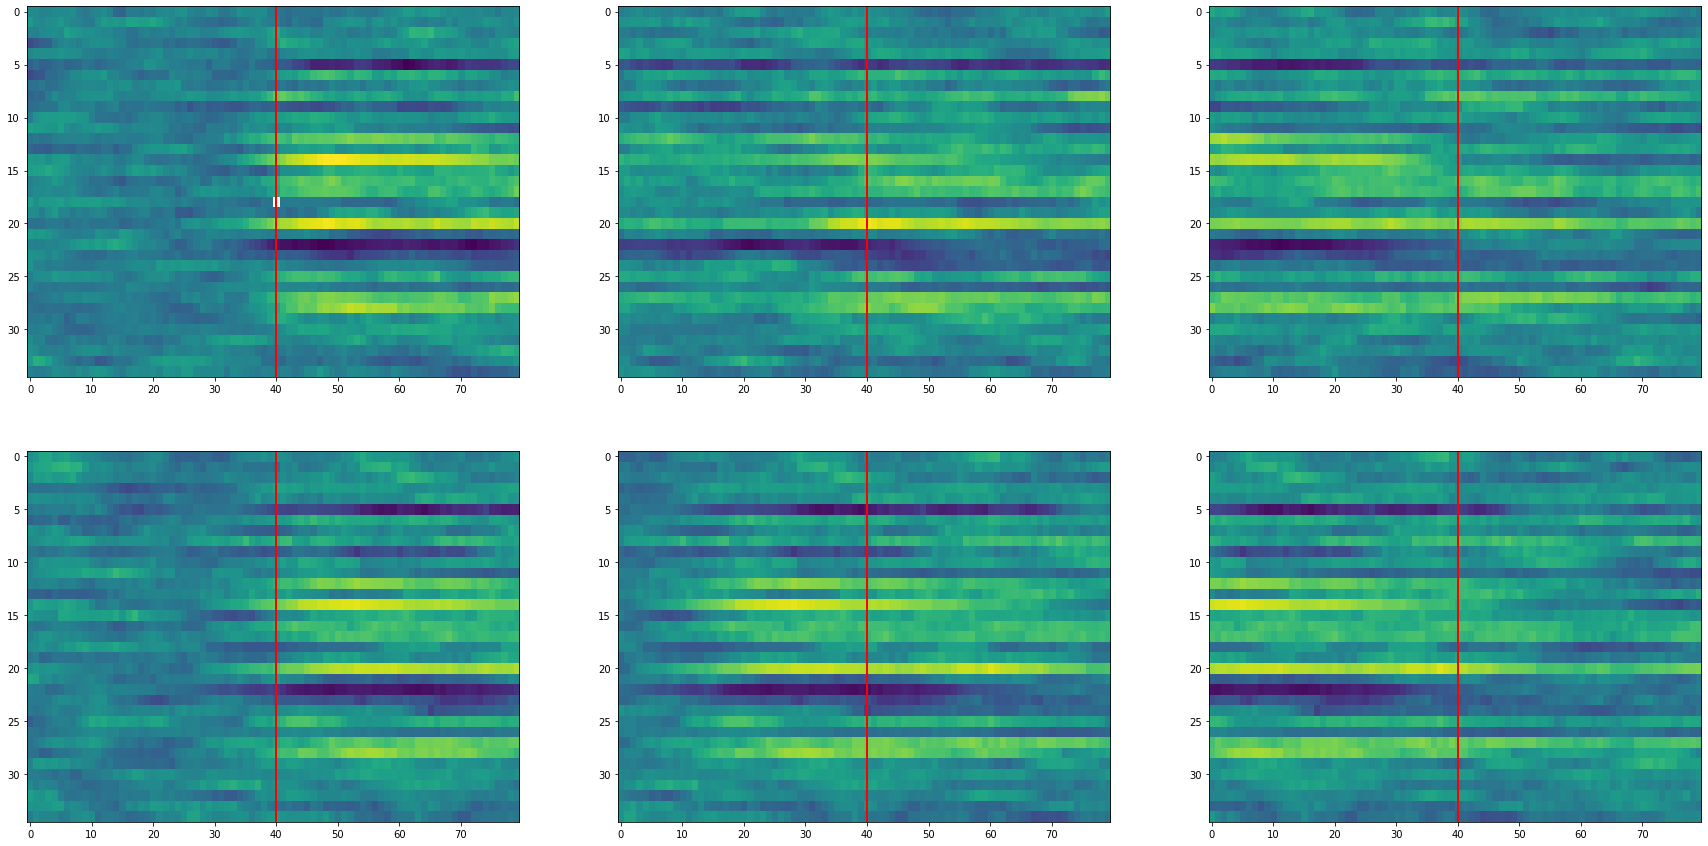

In [505]:
all_corrs = np.concatenate((aligned_spearman,unaligned_spearman))
min_val,max_val = np.nanmin(all_corrs,axis=None),np.nanmax(all_corrs,axis=None)
fig, ax = plt.subplots(2,states-1,figsize = (30,15))
for num,state in enumerate(aligned_spearman.swapaxes(0,1)):
    ax[0,num].imshow(state,aspect='auto',vmin=min_val, vmax = max_val)
    ax[0,num].axvline(x = state.shape[1]//2, ymin = 0, ymax = state.shape[0],c='red',linewidth=2)
for num,state in enumerate(unaligned_spearman.swapaxes(0,1)):
    ax[1,num].imshow(state,aspect='auto',vmin=min_val, vmax = max_val)
    ax[1,num].axvline(x = state.shape[1]//2, ymin = 0, ymax = state.shape[0],c='red',linewidth=2)

In [506]:
# Is the difference improved by "good" trials
good_pal_vec = pal_vec[good_trial_list]
good_aligned_dat_for_corr = aligned_dat_for_corr[...,good_trial_list]
print(good_aligned_dat_for_corr.shape)
good_aligned_inds = list(np.ndindex(good_aligned_dat_for_corr.shape[:-1]))
good_aligned_spearman = np.zeros(good_aligned_dat_for_corr.shape[:-1])
for this_ind in good_aligned_inds:
    good_aligned_spearman[this_ind] = spearmanr(good_aligned_dat_for_corr[this_ind], good_pal_vec)[0]

print(good_aligned_spearman.shape)
# good_mean_aligned_spearman_r = np.abs(np.nanmean(good_aligned_spearman,axis=0))
good_mean_aligned_spearman_r = np.nanmean(np.abs(good_aligned_spearman),axis=0)

(35, 3, 80, 15)
(35, 3, 80)


In [507]:
good_unaligned_dat_for_corr = unaligned_dat_for_corr[...,good_trial_list]
print(good_unaligned_dat_for_corr.shape)
good_unaligned_inds = list(np.ndindex(good_unaligned_dat_for_corr.shape[:-1]))
good_unaligned_spearman = np.zeros(good_unaligned_dat_for_corr.shape[:-1])
for this_ind in good_unaligned_inds:
    good_unaligned_spearman[this_ind] = spearmanr(good_unaligned_dat_for_corr[this_ind], good_pal_vec)[0]

print(good_unaligned_spearman.shape)
# good_mean_unaligned_spearman_r = np.abs(np.nanmean(good_unaligned_spearman,axis=0))
good_mean_unaligned_spearman_r = np.nanmean(np.abs(good_unaligned_spearman),axis=0)

(35, 3, 80, 15)
(35, 3, 80)


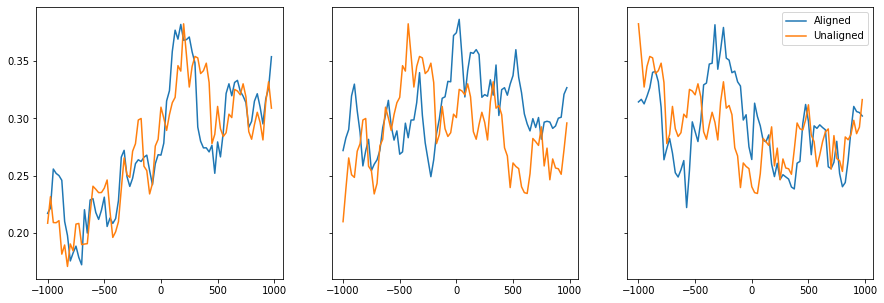

In [508]:
fig, ax = plt.subplots(1,states-1, figsize=(15,5),sharey=True)
for change in range(states-1):
    ax[change].plot(t_align, good_mean_aligned_spearman_r[change],label = 'Aligned')
    ax[change].plot(t_align, good_mean_unaligned_spearman_r[change], label = 'Unaligned')
plt.legend()

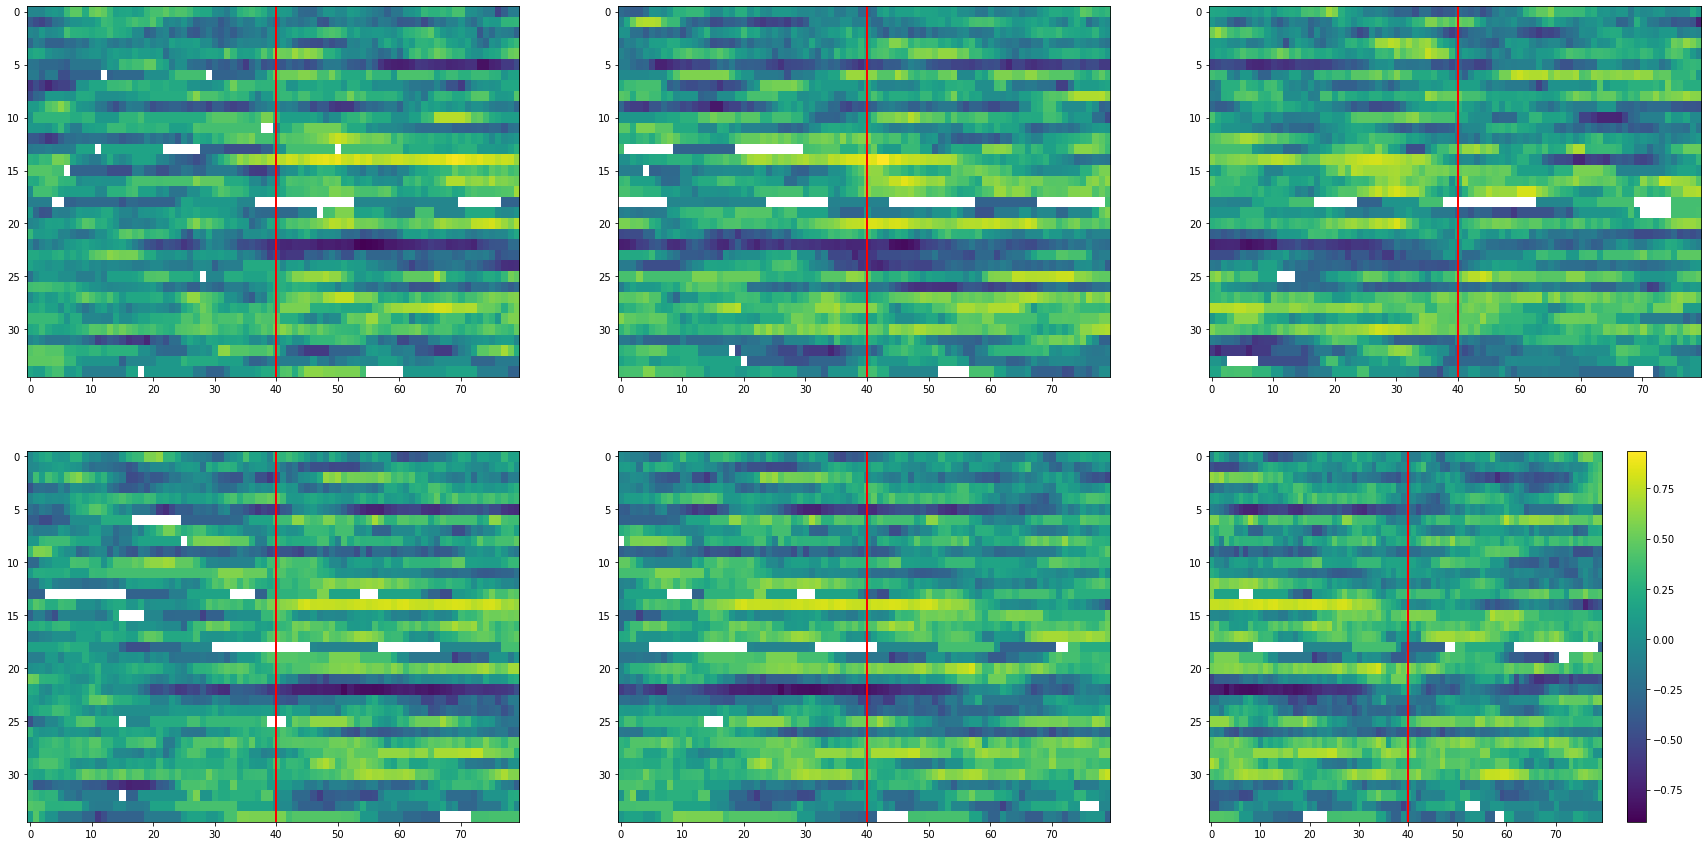

In [509]:
all_corrs = np.concatenate((good_aligned_spearman,good_unaligned_spearman))
min_val,max_val = np.nanmin(all_corrs,axis=None),np.nanmax(all_corrs,axis=None)
fig, ax = plt.subplots(2,states-1,figsize = (30,15))
for num,state in enumerate(good_aligned_spearman.swapaxes(0,1)):
    ax[0,num].imshow(state,aspect='auto',vmin=min_val, vmax = max_val)
    ax[0,num].axvline(x = state.shape[1]//2, ymin = 0, ymax = state.shape[0],c='red',linewidth=2)
for num,state in enumerate(good_unaligned_spearman.swapaxes(0,1)):
    im = ax[1,num].imshow(state,aspect='auto',vmin=min_val, vmax = max_val)
    ax[1,num].axvline(x = state.shape[1]//2, ymin = 0, ymax = state.shape[0],c='red',linewidth=2)
plt.colorbar(im)

In [510]:
# Calculate correlation of average firing rate in each state to palatability
# There should be a single DOMINANT palatability state
print(int_mean_tau.shape)
time_lim_inds = np.array(time_lims)//firing_bin_width
print(time_lim_inds)
bounding_mean_tau = np.hstack((np.repeat(time_lim_inds[0],int_mean_tau.shape[0])[:,np.newaxis],
                              int_mean_tau,
                              np.repeat(time_lim_inds[1],int_mean_tau.shape[0])[:,np.newaxis]))
# print(bounding_mean_tau)

(120, 3)
[ 80 180]


In [511]:
print(firing_long.shape)
mean_state_firing = np.zeros((states,*firing_long.shape[:-1]))
print(mean_state_firing.shape)
inds = list(np.ndindex(mean_state_firing.shape[:-1]))
for this_ind in inds:
    temp_firing = firing_long[this_ind[1:]]
    temp_inds = bounding_mean_tau[this_ind[1],this_ind[0]:(this_ind[0]+2)]
    mean_state_firing[this_ind] = np.mean(temp_firing[:,temp_inds[0]:temp_inds[1]],axis=-1)

(120, 35, 271)
(4, 120, 35)


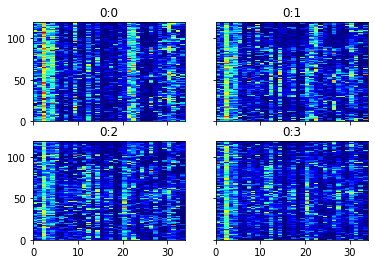

In [512]:
# visualize.firing_overview(stats.zscore(mean_state_firing,axis=1));
visualize.firing_overview(mean_state_firing);

In [513]:
# For each state, correlate the acticity of all the neurons to palatability
# And compare with mean firing of non-aligned windows of time
mean_firing_for_corr = np.swapaxes(mean_state_firing,-2,-1)
mean_firing_corrs = np.zeros(mean_firing_for_corr.shape[:-1])
print(mean_firing_for_corr.shape)
ndinds = list(np.ndindex(mean_firing_for_corr.shape[:-1]))
for this_ind in ndinds:
     mean_firing_corrs[this_ind] = \
        spearmanr(mean_firing_for_corr[this_ind], pal_vec)[0]
print(mean_firing_corrs.shape)

(4, 35, 120)
(4, 35)


[0.0827564  0.22469202 0.23321971 0.17649014]


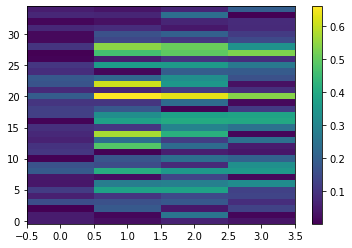

In [514]:
im = visualize.imshow(np.abs(mean_firing_corrs.T))
print(np.mean(np.abs(mean_firing_corrs),axis=1))
plt.colorbar(im);

In [197]:
# Calculate palatability correlation with aligned and unaligned PCs